<a href="https://colab.research.google.com/github/sebdlh2025-wq/recsys/blob/main/Designing_Recommender_Systems_5Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems — 5‑Day Lab Notebook

This notebook is the **main lab material** for our 5‑day block on recommender systems.

We will go from:

- basic *content‑based* recommenders  
- to *personalized* recommenders  
- to *hybrid & constraint‑aware* recommenders  
- to *agentic* recommenders with a simple **critic agent**  
- plus **visualisation**, **interactive filtering**, and **evaluation**

All code is designed to run on **Google Colab**.

---

## Application domains (choose one per group)

In this lab, each group focuses on **one domain**:

1. **Fashion** – personal stylist for clothing items (e‑commerce)  
2. **Recipes** – everyday cooking companion  
3. **Scholar** – paper navigator for research topics  
4. **Movies** – movie night recommender + offline evaluation

We will use the same **pipeline pattern** for all four domains.  
You select the domain via the `PROJECT` variable below.


---
## 0. Global configuration

- `PROJECT` – select one domain per group.  
- `EMBEDDING_MODEL` – you can later play with different models.  
- `MAX_ROWS` – how many items to load (large datasets can be subsampled for speed).


In [70]:
# =========================
# GLOBAL CONFIGURATION
# =========================

# Options: "fashion", "recipes", "scholar", "movies"
PROJECT = "recipes"      # 👈 change this per group

# Text embedding model from sentence-transformers.
# You can later try: "all-mpnet-base-v2", "multi-qa-MiniLM-L6-cos-v1", etc.
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# Control dataset size. If None -> full data; if int -> random subset.
MAX_ROWS = 58000

print("Selected PROJECT:", PROJECT)
print("Embedding model :", EMBEDDING_MODEL)
print("MAX_ROWS        :", MAX_ROWS)


Selected PROJECT: recipes
Embedding model : all-MiniLM-L6-v2
MAX_ROWS        : 58000


---
## 1. Environment setup

We install the libraries we need:

- `sentence-transformers` for text embeddings  
- `ipywidgets` for sliders / interactive filters  
- `gradio` for an optional simple web UI (user‑study sketch)


In [71]:
!pip install sentence-transformers ipywidgets gradio matplotlib --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6470.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6470.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [72]:
!pip install matplotlib-inline nbformat --upgrade --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6477.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6477.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [73]:
import pandas as pd
import numpy as np
import random

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from ipywidgets import interact, widgets
from IPython.display import display, HTML

pd.set_option("display.max_colwidth", 160)


In [74]:
def first_existing(df: pd.DataFrame, candidates):
    """Return the first column from 'candidates' that exists in df."""
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"None of {candidates} found in columns: {df.columns.tolist()}")


def display_gallery(recs: pd.DataFrame,
                    title: str = "Recommendations",
                    text_cols=None):
    """Simple HTML gallery view.

    If an image URL column happens to exist ('image_url', 'img', 'main_image'),
    it will be displayed. Otherwise we show text cards.

    This is intentionally generic and works for all four projects.
    """
    if recs is None or len(recs) == 0:
        display(HTML("<p><i>No items to display.</i></p>"))
        return

    if text_cols is None:
        if PROJECT == "fashion":
            text_cols = ["product_name", "color", "category_tree", "final_price"]
        elif PROJECT == "recipes":
            text_cols = ["title", "ingredients"]
        elif PROJECT == "scholar":
            text_cols = ["title", "abstract"]
        elif PROJECT == "movies":
            text_cols = ["title", "genres"]
        else:
            text_cols = list(recs.columns)

    # try to find an image column if there is one (many datasets won't have it)
    img_col = None
    for c in ["image_url", "img", "main_image"]:
        if c in recs.columns:
            img_col = c
            break

    cards_html = []
    for _, row in recs.iterrows():
        # build text part
        parts = []
        for col in text_cols:
            if col in recs.columns:
                val = str(row[col])
                parts.append(f"<div><b>{col}</b>: {val}</div>")

        # build image part if available
        img_html = ""
        if img_col is not None and isinstance(row.get(img_col), str):
            url = row[img_col]
            if url and url.startswith("http"):
                img_html = f"""
                <div style='height:150px; overflow:hidden; margin-bottom:6px;'>
                    <img src='{url}' style='width:100%; object-fit:cover;'>
                </div>
                """

        card = f"""
        <div style='width:230px; margin:8px; padding:10px; border-radius:12px;
                    box-shadow:0 2px 6px rgba(0,0,0,0.1); background:white; font-size:12px;'>
            {img_html}
            {''.join(parts)}
        </div>
        """
        cards_html.append(card)

    html = f"""
    <h3>{title}</h3>
    <div style='display:flex; flex-wrap:wrap; gap:6px; background:#f5f5f5; padding:10px; border-radius:12px;'>
        {''.join(cards_html)}
    </div>
    """
    display(HTML(html))


---
# 📅 Day 1 — Data, Item Representations & Content-Based Recommendation

### Goals

- Load a **real dataset** for your chosen domain.  
- Turn items into **vector representations** (embeddings).  
- Compute **content-based similarity** between items.  
- Visualise the embedding space in **2D and 3D**.


## 1.1 Load a real dataset

We work with four public datasets:

- **Fashion**: sample of H&M product catalogue (titles, descriptions, color, category, price).  
- **Recipes**: ~13k recipes (title, ingredients, instructions).  
- **Scholar**: AI-generated vs human-like abstracts (we treat them as "papers").  
- **Movies**: MovieLens `ml-latest-small` movies + ratings.

We always return:

- `df` — item table (one row per item)  
- `ratings` — optional rating table (only for movies; used later for offline evaluation)


In [75]:
FASHION_URL = "https://raw.githubusercontent.com/luminati-io/HM-dataset-sample/main/H%26M-dataset-sample.csv"
RECIPES_URL = "https://raw.githubusercontent.com/josephrmartinez/recipe-dataset/main/13k-recipes.csv"
SCHOLAR_URL = "https://raw.githubusercontent.com/panagiotisanagnostou/AI-GA/main/ai-ga-dataset.csv"
MOVIES_URL  = "https://raw.githubusercontent.com/maharjansudhan/DATA612/master/ml-latest-small/movies.csv"
RATINGS_URL = "https://raw.githubusercontent.com/maharjansudhan/DATA612/master/ml-latest-small/ratings.csv"

def load_project_data(project: str):
    ratings = None

    if project == "fashion":
        df = pd.read_csv(FASHION_URL)
        # keep core columns
        keep = [c for c in ["product_name", "description", "color", "category_tree", "final_price"] if c in df.columns]
        df = df[keep].dropna(subset=[keep[0]]).reset_index(drop=True)
        df["id"] = df.index.astype(str)
        # Clean and convert final_price to numeric
        if "final_price" in df.columns:
            df["final_price"] = df["final_price"].astype(str).str.replace('"', '').str.replace('$', '', regex=False)
            df["final_price"] = pd.to_numeric(df["final_price"], errors='coerce')

    elif project == "recipes":
        df = pd.read_csv(RECIPES_URL)
        title_col = first_existing(df, ["Title", "title"])
        ing_col   = first_existing(df, ["Ingredients", "ingredients"])
        instr_col = first_existing(df, ["Instructions", "instructions", "Directions"])
        df = df[[title_col, ing_col, instr_col]].rename(columns={title_col: "title",
                                                                 ing_col: "ingredients",
                                                                 instr_col: "instructions"})
        df = df.dropna().reset_index(drop=True)
        df["id"] = df.index.astype(str)

    elif project == "scholar":
        df = pd.read_csv(SCHOLAR_URL)
        title_col    = first_existing(df, ["title", "Title"])
        abstract_col = first_existing(df, ["abstract", "Abstract", "text"])
        label_col    = first_existing(df, ["label", "Label"])
        df = df[[title_col, abstract_col, label_col]].rename(columns={title_col: "title",
                                                                      abstract_col: "abstract",
                                                                      label_col: "label"})
        df = df.dropna().reset_index(drop=True)
        df["id"] = df.index.astype(str)

    elif project == "movies":
        movies  = pd.read_csv(MOVIES_URL)
        ratings = pd.read_csv(RATINGS_URL)
        movies["id"] = movies["movieId"].astype(str)
        df = movies[["id", "title", "genres"]].dropna().reset_index(drop=True)
    else:
        raise ValueError("PROJECT must be one of: fashion, recipes, scholar, movies")

    # Optional sampling for speed
    if MAX_ROWS is not None and len(df) > MAX_ROWS:
        df = df.sample(MAX_ROWS, random_state=42).reset_index(drop=True)

    return df, ratings


df, ratings = load_project_data(PROJECT)
print(f"Loaded {len(df)} items for project='{PROJECT}'. Columns: {df.columns.tolist()}")
df.head()

Loaded 13493 items for project='recipes'. Columns: ['title', 'ingredients', 'instructions', 'id']


,title,ingredients,instructions,id
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp...","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.\nMeanwhil...",0
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (about 1 inch in diameter)', '2 teaspoons kosher salt', '¾ teaspoon finely ground black pepper', '1 teaspoon fi...","Preheat oven to 400°F and line a rimmed baking sheet with parchment. In a large bowl, whisk the egg whites until foamy (there shouldn’t be any liquid whites...",1
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', '1 tsp. garlic powder', '1 tsp. onion powder', '1 tsp. smoked paprika', '½ tsp. freshly ground black pepper', ...",Place a rack in middle of oven; preheat to 400°. Bring evaporated milk and whole milk to a bare simmer in a large saucepan over medium heat. Whisk in garlic...,2
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut into 1-inch cubes (8 cups)', '2 tablespoons olive oil, divided', '2 pounds sweet Italian sausage, casings remove...","Preheat oven to 350°F with rack in middle. Generously butter baking dish.\nPut bread in 2 shallow baking pans and bake, switching position of pans halfway t...",3
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon hot water', '1 ½ oz. bourbon', '½ oz. fresh lemon juice', '2 teaspoons apple butter (storebought or homemade)', ...","Stir together brown sugar and hot water in a cocktail shaker to dissolve. Let cool, then add bourbon, lemon juice, and apple butter and fill with ice. Shake...",4


### 1.2 Quick data sanity check

Always inspect a few rows and some basic statistics before building recommenders.


In [76]:
print("Shape:", df.shape)
display(df.head(5))
display(df.describe(include='all').transpose().head(10))


Shape: (13493, 4)


,title,ingredients,instructions,id
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp...","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.\nMeanwhil...",0
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (about 1 inch in diameter)', '2 teaspoons kosher salt', '¾ teaspoon finely ground black pepper', '1 teaspoon fi...","Preheat oven to 400°F and line a rimmed baking sheet with parchment. In a large bowl, whisk the egg whites until foamy (there shouldn’t be any liquid whites...",1
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', '1 tsp. garlic powder', '1 tsp. onion powder', '1 tsp. smoked paprika', '½ tsp. freshly ground black pepper', ...",Place a rack in middle of oven; preheat to 400°. Bring evaporated milk and whole milk to a bare simmer in a large saucepan over medium heat. Whisk in garlic...,2
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut into 1-inch cubes (8 cups)', '2 tablespoons olive oil, divided', '2 pounds sweet Italian sausage, casings remove...","Preheat oven to 350°F with rack in middle. Generously butter baking dish.\nPut bread in 2 shallow baking pans and bake, switching position of pans halfway t...",3
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon hot water', '1 ½ oz. bourbon', '½ oz. fresh lemon juice', '2 teaspoons apple butter (storebought or homemade)', ...","Stir together brown sugar and hot water in a cocktail shaker to dissolve. Let cool, then add bourbon, lemon juice, and apple butter and fill with ice. Shake...",4


,count,unique,top,freq
title,13493,13302,French 75,5
ingredients,13493,13471,[],6
instructions,13493,13464,Place ingredients in blender in the order listed and blend until smooth.,5
id,13493,13493,0,1


In [77]:
# --- Add complexity columns: number of strings in ingredients & instructions
import ast
import json

def _count_strings(text):
    """Return the number of string items represented in `text`.

    Handles common formats:
    - JSON arrays or Python list literals (e.g. "[\"a\", \"b\"]")
    - newline-separated lists
    - separators: '||', '|', ';'
    - fallback: treat the whole field as a single string (count = 1)

    Empty / NaN values return 0.
    """
    if pd.isna(text) or not str(text).strip():
        return 0
    s = str(text).strip()

    # 1) Try JSON array
    try:
        parsed = json.loads(s)
        if isinstance(parsed, list):
            return len(parsed)
    except Exception:
        pass

    # 2) Try Python literal (list / tuple)
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple, set)):
            return len(parsed)
    except Exception:
        pass

    # 3) Newline-separated items
    if "\n" in s:
        parts = [p.strip() for p in s.splitlines() if p.strip()]
        if len(parts) > 1:
            return len(parts)

    # 4) Common separators used in some CSV exports
    for sep in ("||", "|", ";", "'", "\""):
        if sep in s:
            parts = [p.strip() for p in s.split(sep) if p.strip()]
            if len(parts) > 1:
                return len(parts)

    # 5) Fallback: single non-empty string
    return 1


def _count_sentences(text):
    """Return the number of sentences in `text`.
    
    A sentence is marked by a full stop (.).
    Empty / NaN values return 0.
    """
    if pd.isna(text) or not str(text).strip():
        return 0
    s = str(text).strip()
    # Count periods (sentences)
    return s.count('.')


# Only add columns if the relevant source columns exist
if "ingredients" in df.columns:
    df["ingredients_sentences"] = df["ingredients"].apply(_count_strings)

if "instructions" in df.columns:
    df["instructions_sentences"] = df["instructions"].apply(_count_sentences)

print("Added complexity columns where applicable:")
print("  - ingredients_sentences: based on number of strings")
print("  - instructions_sentences: based on number of sentences (full stops)")

# Show a quick sample
cols = [c for c in ["ingredients_sentences", "instructions_sentences"] if c in df.columns]
if cols:
    display(df[cols].head())


Added complexity columns where applicable:
  - ingredients_sentences: based on number of strings
  - instructions_sentences: based on number of sentences (full stops)


,ingredients_sentences,instructions_sentences
0,21,37
1,7,6
2,10,14
3,13,18
4,6,5


In [78]:
# --- Estimate preparation time and cooking time from instructions
import re

def _estimate_prep_and_cook_time(instructions_text):
    """
    Extract or estimate preparation and cooking time from instructions text.
    
    Returns: (prep_time_minutes, cook_time_minutes)
    
    Searches for patterns like:
    - "prep time: 10 minutes", "prep: 10 mins", "preparation time: 10"
    - "cook time: 30 minutes", "cooking time: 30 mins", "cook: 30"
    
    If not found explicitly, estimates based on:
    - Number of sentences (heuristic: ~2 min per cooking step)
    - Number of ingredients (heuristic: ~1 min per ingredient prep)
    
    Default: 0 if missing, or estimates if instructions are provided.
    """
    if pd.isna(instructions_text) or not str(instructions_text).strip():
        return 0, 0
    
    text = str(instructions_text).lower()
    
    prep_time = None
    cook_time = None
    
    # ---- PREP TIME ----
    # Try to extract explicit prep time
    prep_patterns = [
        r'prep\s*(?:time)?[:\s]*(\d+)\s*(?:min|minute)',
        r'preparation\s*(?:time)?[:\s]*(\d+)\s*(?:min|minute)',
    ]
    for pattern in prep_patterns:
        match = re.search(pattern, text)
        if match:
            prep_time = int(match.group(1))
            break
    
    # ---- COOK TIME ----
    # Try to extract explicit cook time
    cook_patterns = [
        r'(?:cook|bake|simmer|roast)\s*(?:time)?[:\s]*(\d+)\s*(?:min|minute)',
        r'cooking\s*(?:time)?[:\s]*(\d+)\s*(?:min|minute)',
    ]
    for pattern in cook_patterns:
        match = re.search(pattern, text)
        if match:
            cook_time = int(match.group(1))
            break
    
    # ---- FALLBACK ESTIMATION ----
    if prep_time is None or cook_time is None:
        # Estimate based on instructions complexity
        num_sentences = text.count('.')
        
        if prep_time is None:
            # Heuristic: ~3-5 min per instruction step for prep
            prep_time = max(5, min(30, num_sentences * 3))
        
        if cook_time is None:
            # Heuristic: ~5-8 min per instruction step for cooking
            cook_time = max(10, min(120, num_sentences * 5))
    
    return prep_time, cook_time


# Add time columns if instructions exist
if "instructions" in df.columns:
    time_data = df["instructions"].apply(_estimate_prep_and_cook_time)
    df["prep_time_minutes"] = time_data.apply(lambda x: x[0])
    df["cook_time_minutes"] = time_data.apply(lambda x: x[1])
    df["total_time_minutes"] = df["prep_time_minutes"] + df["cook_time_minutes"]
    
    print("Added time estimation columns:")
    print("  - prep_time_minutes: estimated preparation time")
    print("  - cook_time_minutes: estimated cooking time")
    print("  - total_time_minutes: sum of prep + cook time")
    print("\nSample of time estimates:")
    display(df[["prep_time_minutes", "cook_time_minutes", "total_time_minutes"]].head(10))
else:
    print("Instructions column not found; skipping time estimation.")


Added time estimation columns:
  - prep_time_minutes: estimated preparation time
  - cook_time_minutes: estimated cooking time
  - total_time_minutes: sum of prep + cook time

Sample of time estimates:


,prep_time_minutes,cook_time_minutes,total_time_minutes
0,30,120,150
1,18,30,48
2,30,70,100
3,30,90,120
4,15,25,40
5,21,35,56
6,24,40,64
7,30,70,100
8,30,120,150
9,30,120,150


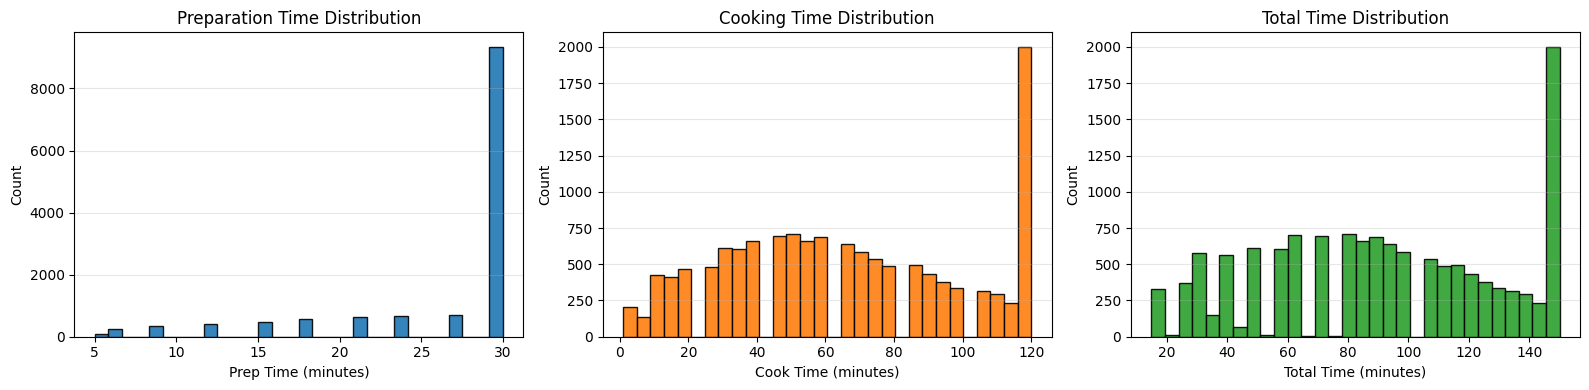


Time Statistics:
Prep Time - Mean: 26.4 min, Median: 30.0 min, Max: 30 min
Cook Time - Mean: 65.8 min, Median: 60.0 min, Max: 120 min
Total Time - Mean: 92.2 min, Median: 90.0 min, Max: 150 min


In [79]:
# --- Plot distributions for preparation and cooking time
import matplotlib.pyplot as plt

if "prep_time_minutes" in df.columns and "cook_time_minutes" in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Histogram for prep time
    axes[0].hist(df["prep_time_minutes"], bins=30, color="C0", alpha=0.9, edgecolor="black")
    axes[0].set_title("Preparation Time Distribution")
    axes[0].set_xlabel("Prep Time (minutes)")
    axes[0].set_ylabel("Count")
    axes[0].grid(axis="y", alpha=0.3)

    # Histogram for cook time
    axes[1].hist(df["cook_time_minutes"], bins=30, color="C1", alpha=0.9, edgecolor="black")
    axes[1].set_title("Cooking Time Distribution")
    axes[1].set_xlabel("Cook Time (minutes)")
    axes[1].set_ylabel("Count")
    axes[1].grid(axis="y", alpha=0.3)

    # Histogram for total time
    axes[2].hist(df["total_time_minutes"], bins=30, color="C2", alpha=0.9, edgecolor="black")
    axes[2].set_title("Total Time Distribution")
    axes[2].set_xlabel("Total Time (minutes)")
    axes[2].set_ylabel("Count")
    axes[2].grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nTime Statistics:")
    print(f"Prep Time - Mean: {df['prep_time_minutes'].mean():.1f} min, Median: {df['prep_time_minutes'].median():.1f} min, Max: {df['prep_time_minutes'].max():.0f} min")
    print(f"Cook Time - Mean: {df['cook_time_minutes'].mean():.1f} min, Median: {df['cook_time_minutes'].median():.1f} min, Max: {df['cook_time_minutes'].max():.0f} min")
    print(f"Total Time - Mean: {df['total_time_minutes'].mean():.1f} min, Median: {df['total_time_minutes'].median():.1f} min, Max: {df['total_time_minutes'].max():.0f} min")
else:
    print("Time columns not found; skipping time distribution plot.")


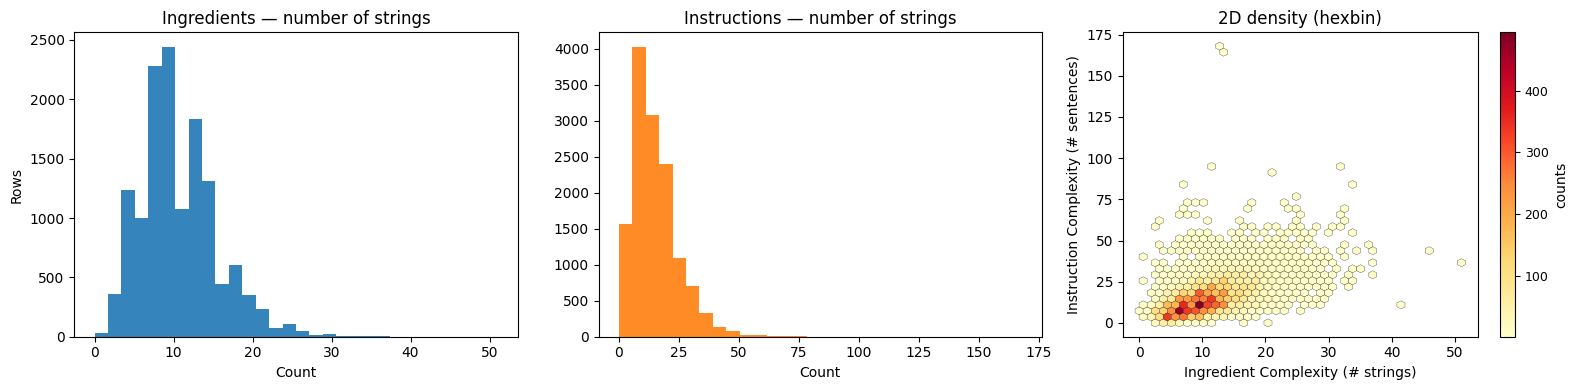

In [80]:
# --- Plot distributions for ingredients_sentences & instructions_sentences
import matplotlib.pyplot as plt

plot_cols = []
if "ingredients_sentences" in df.columns:
    # ensure numeric
    df["ingredients_sentences"] = pd.to_numeric(df["ingredients_sentences"], errors="coerce").fillna(0).astype(int)
    plot_cols.append("ingredients_sentences")
if "instructions_sentences" in df.columns:
    df["instructions_sentences"] = pd.to_numeric(df["instructions_sentences"], errors="coerce").fillna(0).astype(int)
    plot_cols.append("instructions_sentences")

if not plot_cols:
    print("No ingredients/instructions sentence-count columns available to plot.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Histogram for ingredients
    if "ingredients_sentences" in plot_cols:
        axes[0].hist(df["ingredients_sentences"], bins=30, color="C0", alpha=0.9)
        axes[0].set_title("Ingredients — number of strings")
        axes[0].set_xlabel("Count")
        axes[0].set_ylabel("Rows")
    else:
        axes[0].axis("off")

    # Histogram for instructions
    if "instructions_sentences" in plot_cols:
        axes[1].hist(df["instructions_sentences"], bins=30, color="C1", alpha=0.9)
        axes[1].set_title("Instructions — number of strings")
        axes[1].set_xlabel("Count")
    else:
        axes[1].axis("off")

    # 2D density / hexbin when both available
    if len(plot_cols) == 2:
        x = df["ingredients_sentences"]
        y = df["instructions_sentences"]
        hb = axes[2].hexbin(x, y, gridsize=40, cmap="YlOrRd", mincnt=1, edgecolors="black", linewidths=0.2)
        axes[2].set_xlabel("Ingredient Complexity (# strings)")
        axes[2].set_ylabel("Instruction Complexity (# sentences)")
        axes[2].set_title("2D density (hexbin)")
        cbar = fig.colorbar(hb, ax=axes[2], label="counts")
        cbar.ax.tick_params(labelsize=9)
    else:
        axes[2].axis("off")

    plt.tight_layout()
    plt.show()


## 1.3 Item embeddings

We convert text fields into dense vectors using a pre‑trained `SentenceTransformer` model:

- Fashion: product name + description + category  
- Recipes: title + ingredients  
- Scholar: title + abstract  
- Movies: title + genres


In [81]:
text_model = SentenceTransformer(EMBEDDING_MODEL)

if PROJECT == "fashion":
    texts = (df["product_name"].fillna("") + " " +
             df["description"].fillna("") + " " +
             df.get("category_tree", "").fillna("")).tolist()

elif PROJECT == "recipes":
    texts = (df["title"].fillna("") + " " +
             df["ingredients"].fillna("")).tolist()

elif PROJECT == "scholar":
    texts = (df["title"].fillna("") + " " +
             df["abstract"].fillna("")).tolist()

else:  # movies
    texts = (df["title"].fillna("") + " " +
             df["genres"].fillna("")).tolist()

print("Encoding", len(texts), "items with model:", EMBEDDING_MODEL)
embeddings = text_model.encode(texts, show_progress_bar=True)
print("Embeddings shape:", embeddings.shape)


Encoding 13493 items with model: all-MiniLM-L6-v2


Batches:   0%|          | 0/422 [00:00<?, ?it/s]

Embeddings shape: (13493, 384)


In [82]:
df.describe()


,ingredients_sentences,instructions_sentences,prep_time_minutes,cook_time_minutes,total_time_minutes
count,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000
mean,10.648781,15.095086,26.395983,65.803305,92.199289
std,4.826155,9.640734,6.545646,35.155345,39.754793
min,0.000000,0.000000,5.000000,1.000000,15.000000
25%,7.000000,8.000000,24.000000,40.000000,64.000000
50%,10.000000,13.000000,30.000000,60.000000,90.000000
75%,13.000000,20.000000,30.000000,95.000000,125.000000
max,51.000000,168.000000,30.000000,120.000000,150.000000


In [83]:
df['title']

0                     Miso-Butter Roast Chicken With Acorn Squash Panzanella
1                                            Crispy Salt and Pepper Potatoes
2                                                Thanksgiving Mac and Cheese
3                                         Italian Sausage and Bread Stuffing
4                                                               Newton's Law
                                        ...                                 
13488                                                   Brownie Pudding Cake
13489     Israeli Couscous with Roasted Butternut Squash and Preserved Lemon
13490                    Rice with Soy-Glazed Bonito Flakes and Sesame Seeds
13491                                                            Spanakopita
13492    Mexican Poblano, Spinach, and Black Bean "Lasagne" with Goat Cheese
Name: title, Length: 13493, dtype: object

In [84]:
df.columns

Index(['title', 'ingredients', 'instructions', 'id', 'ingredients_sentences',
       'instructions_sentences', 'prep_time_minutes', 'cook_time_minutes',
       'total_time_minutes'],
      dtype='object')

In [85]:
!pip install Wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6738.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6738.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [86]:
from wordcloud import WordCloud

In [ ]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Combine all text from title, ingredients, and instructions
all_text = " ".join(
    df["title"].fillna("") + " " +
    df["ingredients"].fillna("") + " " +
    df["instructions"].fillna("")
)

# Generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis",
    max_words=100
).generate(all_text)

# Display
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Recipe Titles, Ingredients, and Instructions", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [87]:
print("OK")

OK


## 1.4 Visualising the embedding space (2D & 3D PCA)

We reduce the high‑dimensional embeddings with PCA for exploration.

> This is only for **intuition** — we are NOT training on the 2D/3D projections.


In [88]:
!pip install plotly --quiet


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6744.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6744.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [89]:
# ============================================
# ✅ INTERACTIVE 2D + 3D EMBEDDING MAP
# ============================================

!pip install plotly --quiet

import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA

# -----------------------------
# 1.CHOOSES COLOR HERE
# -----------------------------
# Examples students can try:
# Fashion → "category_tree", "color"
# Recipes → "complexity"
# Scholar → "label"
# Movies  → "main_genre"

COLOR_BY = "complexity"   # 👈 e.g. "category_tree" or "label" or "main_genre" or None

# -----------------------------
# 2. SAMPLE EMBEDDINGS
# -----------------------------
max_points = min(1500, len(df))
idx_sample = np.random.choice(len(df), max_points, replace=False)
X_sample = embeddings[idx_sample]
df_sample = df.iloc[idx_sample].reset_index(drop=True)

# -----------------------------
# 3. SAFE HOVER LABEL
# -----------------------------
if PROJECT == "fashion" and "product_name" in df_sample.columns:
    hover_col = "product_name"
elif "title" in df_sample.columns:
    hover_col = "title"
else:
    hover_col = df_sample.columns[0]

# -----------------------------
# 4. DERIVED COLOR FEATURES (SAFE)
# -----------------------------
# Recipes: numeric complexity
if PROJECT == "recipes" and "ingredients" in df_sample.columns:
    # df_sample["complexity"] = df_sample["ingredients"].apply(lambda x: len(str(x)))
    df_sample["complexity"] = df_sample["ingredients"].apply(lambda x: len(str(x)))

# Movies: first genre
if PROJECT == "movies" and "genres" in df_sample.columns:
    df_sample["main_genre"] = df_sample["genres"].astype(str).apply(lambda x: x.split("|")[0])

# -----------------------------
# 5. PCA REDUCTION
# -----------------------------
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_sample)

df_sample["pc1"] = X_2d[:, 0]
df_sample["pc2"] = X_2d[:, 1]

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_sample)

df_sample["pc3"] = X_3d[:, 2]

# -----------------------------
# 6. INTERACTIVE 2D PLOT (WITH LEGEND)
# -----------------------------
fig_2d = px.scatter(
    df_sample,
    x="pc1",
    y="pc2",
    color=COLOR_BY,          # ✅ LEGEND APPEARS HERE
    hover_data=[hover_col],
    title=f"{PROJECT.capitalize()} — 2D Embedding Map (Color by: {COLOR_BY})"
)

fig_2d.update_traces(marker=dict(size=6, opacity=0.85))
fig_2d.show()

# -----------------------------
# 7. INTERACTIVE 3D PLOT (WITH LEGEND)
# -----------------------------
fig_3d = px.scatter_3d(
    df_sample,
    x="pc1",
    y="pc2",
    z="pc3",
    color=COLOR_BY,          # ✅ LEGEND APPEARS HERE
    hover_data=[hover_col],
    title=f"{PROJECT.capitalize()} — 3D Embedding Map (Color by: {COLOR_BY})"
)

fig_3d.update_traces(marker=dict(size=4, opacity=0.9))
fig_3d.show()

# -----------------------------
# 8. SAFETY CHECK MESSAGE
# -----------------------------
if COLOR_BY is not None and COLOR_BY not in df_sample.columns:
    print(f"⚠️ WARNING: '{COLOR_BY}' is not a column in this dataset.")
    print("Available columns:", df_sample.columns.tolist())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6750.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6750.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [90]:
df.columns

Index(['title', 'ingredients', 'instructions', 'id', 'ingredients_sentences',
       'instructions_sentences', 'prep_time_minutes', 'cook_time_minutes',
       'total_time_minutes'],
      dtype='object')

## 1.5 Content‑based recommendation

We implement the simplest possible model:

> **Given an item A, recommend items whose embedding is most similar to A.**

We use **cosine similarity** between the embedding of the query item and all others.


In [91]:
# ============================================
# ✅ INTERACTIVE RATING-BASED RECOMMENDER (FIXED)
# ============================================

import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 1. SAMPLE 5 RANDOM ITEMS
# -----------------------------
np.random.seed(42)
seed_indices = np.random.choice(len(df), 5, replace=False)
seed_items = df.iloc[seed_indices].reset_index(drop=True)

# -----------------------------
# 2. CLEAN CARD-STYLE DISPLAY
# -----------------------------
def clean_gallery(recs, title="Gallery"):
    cards = []
    for _, r in recs.iterrows():
        name = str(r.get("product_name", r.get("title", "Item")))
        color = str(r.get("color", ""))
        price = str(r.get("final_price", ""))
        cat = str(r.get("category_tree", r.get("genres", ""))).split("},")[0]

        card = f"""
        <div style="width:240px; padding:10px; margin:8px;
                    background:white; border-radius:12px;
                    box-shadow:0 2px 6px rgba(0,0,0,0.15); font-size:13px;">
            <b>{name}</b><br>
            {color}<br>
            {price}<br>
            <small>{cat[:80]}...</small>
        </div>
        """
        cards.append(card)

    html = f"""
    <h3>{title}</h3>
    <div style="display:flex; flex-wrap:wrap; background:#f5f5f5; padding:10px;">
        {''.join(cards)}
    </div>
    """
    display(widgets.HTML(value=html))


# -----------------------------
# 3. SHOW 5 ITEMS TO RATE
# -----------------------------
sliders = []
ui_blocks = []

for i in range(5):
    row = seed_items.iloc[i]
    name = str(row.get("product_name", row.get("title", "Item")))
    color = str(row.get("color", ""))
    price = str(row.get("final_price", ""))

    slider = widgets.IntSlider(value=3, min=1, max=5, step=1, description="Rating:")
    sliders.append(slider)

    text = f"<b>{name}</b><br>{color}<br>{price}"

    block = widgets.VBox([
        widgets.HTML(value=text),   # ✅ FIX: widget HTML
        slider
    ])

    ui_blocks.append(block)

display(widgets.HTML(value="<h2>Rate These 5 Items (1 = dislike, 5 = love)</h2>"))
display(widgets.HBox(ui_blocks))

# -----------------------------
# 4. BUILD USER PROFILE FROM RATINGS
# -----------------------------
def build_user_vector_from_ratings(indices, sliders):
    weighted_vecs = []
    weights = []

    for idx, s in zip(indices, sliders):
        w = s.value
        weighted_vecs.append(embeddings[idx] * w)
        weights.append(w)

    user_vec = np.sum(weighted_vecs, axis=0) / np.sum(weights)
    return user_vec.reshape(1, -1)


# -----------------------------
# 5. RECOMMEND BUTTON
# -----------------------------
def on_recommend_clicked(b):
    user_vec = build_user_vector_from_ratings(seed_indices, sliders)

    sims = cosine_similarity(user_vec, embeddings)[0]
    sims[seed_indices] = -1.0   # do not recommend rated items again

    top_idx = np.argsort(sims)[-10:][::-1]
    recs = df.iloc[top_idx].copy()
    recs["score"] = sims[top_idx]

    clean_gallery(recs.head(8), title="🎯 Personalized Recommendations Based on Your Ratings")


recommend_btn = widgets.Button(description="Get My Recommendations", button_style="success")
recommend_btn.on_click(on_recommend_clicked)

display(recommend_btn)


HTML(value='<h2>Rate These 5 Items (1 = dislike, 5 = love)</h2>')

Button(button_style='success', description='Get My Recommendations', style=ButtonStyle())

---
#  Day 2 — User Profiles & Personalized Recommendation

### Idea

Instead of recommending items **similar to a single item**, we want to recommend items **for a user**.

A simple and surprisingly effective trick:

> Represent the user as the **mean of embeddings of items they liked**.


## 2.1 Build a user profile

For three projects we create a **synthetic user**.  
For movies we can **optionally use real MovieLens ratings** if they exist in this subset.


In [92]:
def create_synthetic_user_history(n_likes: int = 8) -> np.ndarray:
    """Randomly pick a set of items as a fake user history."""
    n_likes = min(n_likes, len(df))
    return np.random.choice(len(df), size=n_likes, replace=False)


if PROJECT == "movies" and ratings is not None:
    liked = ratings[ratings["rating"] >= 4.0]
    # Count how many liked movies per user
    counts = liked["userId"].value_counts()
    candidate_users = counts[counts >= 15].index.tolist()
    if candidate_users:
        user_id = random.choice(candidate_users)
        user_ratings = liked[liked["userId"] == user_id]
        movie_ids = set(user_ratings["movieId"].astype(str))
        # map movie ids to indices in df
        id_to_idx = {mid: idx for idx, mid in enumerate(df["id"]) if mid in movie_ids}
        user_indices = np.array(list(id_to_idx.values()))
        if len(user_indices) < 5:  # fallback if overlap is small
            user_indices = create_synthetic_user_history(8)
            user_id = None
    else:
        user_indices = create_synthetic_user_history(8)
        user_id = None
else:
    user_indices = create_synthetic_user_history(8)
    user_id = None

print("User liked item indices:", user_indices.tolist())
if PROJECT == "movies" and user_id is not None:
    print("Real MovieLens user id:", user_id)

display(df.iloc[user_indices].head(len(user_indices)))


User liked item indices: [196, 6354, 3860, 8999, 99, 8785, 11825, 7519]


,title,ingredients,instructions,id,ingredients_sentences,instructions_sentences,prep_time_minutes,cook_time_minutes,total_time_minutes
196,Kong Jaban (Korean Sweet Black Beans),"['1¼ cups dried black beans, rinsed and picked over', '2 quarts dashi or water, plus more if needed', '1 cup soy sauce', '¾ cup sugar', '2 tablespoons toast...","Soak the beans in enough water to cover them by 3 inches in a covered container in the refrigerator for 8 to 12 hours.\nDrain the beans, put them in a pot, ...",196,6,12,30,60,90
6354,Easter Ham with Golden Breadcrumbs and Madeira Sauce,"['1 16-pound whole bone-in smoked ham', '2 cups (packed) dark brown sugar', '1/2 cup Dijon mustard', '1/4 cup extra-virgin olive oil', '3 cups coarse fresh ...","Arrange a rack on lowest level of oven; preheat to 300°F. Without trimming fat, remove outer rind from most of ham, leaving a band around end of shank bone....",6354,7,25,30,120,150
3860,"Chilled Watercress, Spring Nettle, And Sorrel Soup","['2 tablespoons extra virgin olive oil', '2 tablespoons unsalted butter', '1 spring onion, sliced and washed', '2 young leeks, sliced and washed', '2 stalks...","In a large saucepan, warm the olive oil and butter over medium heat until the butter is foamy. Add the onion, leeks, garlic, and salt, and stir to coat. Let...",3860,11,13,30,10,40
8999,Green Pea Soup with Tarragon and Pea Sprouts,"['2 16-ounce packages frozen petite peas, divided (do not thaw)', '2 tablespoons extra-virgin olive oil', '1 1/2 cups sliced shallots (about 11 ounces)', '4...",Place 1 cup peas in microwave-safe bowl; set aside. Heat oil in heavy large saucepan over medium-high heat. Add shallots and sauté until golden and almost t...,8999,7,16,30,80,110
99,Charred-Peach Panzanella With Pickled Pepper Vinaigrette,"['2 garlic cloves, finely grated', '½ cup sliced hot pickled peppers (such as banana peppers), plus 1 Tbsp. pickle brine', '1 Tbsp. stone-ground or whole gr...","Whisk garlic, pickle brine, mustard, and salt in a large bowl to combine. Add tomatoes and pickled peppers and gently toss to combine. Let sit, tossing occa...",99,8,20,30,100,130
8785,"Polenta with Green Beans, Mushrooms, Peas, and Leeks","['3/4 pound green beans, trimmed', '1 cup fresh shelled peas (12 to 14 ounces in pods)', '4 cups whole milk', '2 1/2 cups vegetable broth', '1 3/4 cups pole...","Blanch green beans 1 minute in boiling water. Add peas and cook until both beans and peas are crisp-tender, about 3 minutes. Transfer to bowl of ice water t...",8785,14,30,30,120,150
11825,Chicken Curry with Sweet Potatoes,"['3 tablespoons curry powder, preferably Three Golden Bells brand', '1/2 teaspoon salt, or to taste', '2 pounds skinless chicken thighs', '2 tablespoons veg...",1. Combine 2 tablespoons of the curry powder and the salt in a bowl. Add the chicken and turn to coat the meat evenly. Set aside for 30 minutes.\n2. Heat th...,11825,19,13,30,65,95
7519,"Lamb Chops with Red Onion, Grape Tomatoes, and Feta","['1/2 cup plus 2 tablespoons extra-virgin olive oil', '1/4 cup red wine vinegar', '2 tablespoons fresh lemon juice', '3 garlic cloves, minced', '3 tablespoo...","Whisk 1/2 cup olive oil, red wine vinegar, lemon juice, minced garlic, 2 tablespoons oregano, and ground cumin in medium bowl; season to taste with salt and...",7519,10,12,30,60,90


## 2.2 From liked items to user embedding

We compute the user embedding as the mean of the embeddings of the liked items:

$$
\mathbf{u} = \frac{1}{|L|} \sum_{i \in L} \mathbf{e}_i
$$

where:

- $\mathbf{e}_i$ is the embedding vector of the liked item $i$  
- $L$ is the set of items liked by the user  
- $|L|$ is the number of liked items  

This means that the **user is represented as the centroid of the embeddings of the items they liked** in the latent space.


In [93]:
user_vec = embeddings[user_indices].mean(axis=0, keepdims=True)
user_sims = cosine_similarity(user_vec, embeddings)[0]
user_sims[user_indices] = -1.0  # do not recommend already liked items

def recommend_for_user(user_sims, k: int = 10) -> pd.DataFrame:
    top_idx = np.argsort(user_sims)[-k:][::-1]
    recs = df.iloc[top_idx].copy()
    recs["score"] = user_sims[top_idx]
    return recs


personal_recs = recommend_for_user(user_sims, k=10)
display(personal_recs.head(10))

display_gallery(personal_recs.head(8), title="Personalized recommendations (user embedding)")


,title,ingredients,instructions,id,ingredients_sentences,instructions_sentences,prep_time_minutes,cook_time_minutes,total_time_minutes,score
11585,Stewed-Tomato Bruschetta,"['1/2 cup extra-virgin olive oil', '3 large garlic cloves, thinly sliced lengthwise', '2 Turkish bay leaves or 1 California', '2 whole cloves', '1 celery ri...","Heat oil in a 12-inch heavy skillet over moderate heat until hot but not smoking, then cook garlic, bay leaves, and cloves, stirring, until garlic is golden...",11585,14,9,27,45,72,0.897617
1178,Charred Bean and Pea Salad,"['2 dried chiles de árbol', '6 garlic cloves, smashed', '1 (1 1/2"") piece ginger, peeled, thinly sliced', '3/4 tsp. coarsely ground black pepper', '1/2 tsp....","Cook chiles, garlic, ginger, black pepper, cumin seeds, and 1/3 cup oil in a small saucepan over low heat, swirling occasionally, until garlic is golden and...",1178,10,9,27,45,72,0.894117
2246,"Kale, Snow Pea, and Pork Dumplings","['2 1/2 cups finely shredded kale leaves', '3 1/2 ounces snow peas, trimmed and finely chopped', '2 tablespoons finely chopped water chestnuts', '1/2 cup ci...","Place the kale, snow pea, water chestnut, cilantro, chive, ginger, mirin, oil, pork, salt, and pepper in a large bowl and mix well to combine. Place the wra...",2246,13,7,21,35,56,0.893533
6779,Chicken and Chickpea Stew,"['3/4 cup whole-wheat couscous', '1 pound boneless, skinless chicken breasts', '3/4 teaspoon salt, divided', '1/2 teaspoon freshly ground black pepper, divi...","Cook couscous as directed on package. Season chicken with 1/4 teaspoon salt and 1/4 teaspoon pepper. In a nonstick skillet, heat oil over medium heat. Cook ...",6779,15,12,30,60,90,0.893239
5167,Greens and Grains Scramble,"['4 large eggs, beaten', '1 tablespoon milk', '1/4 teaspoon kosher salt', '2 tablespoons extra-virgin olive oil', '1 green onion, white and light green part...","In a large bowl, whisk together the eggs, milk, and kosher salt; set aside. Heat 1 tablespoon of the olive oil in a sauté pan over medium heat. Add the gree...",5167,12,8,24,40,64,0.893198
10579,Savory Semolina,"['4 cups water', '2 teaspoons coarse kosher salt', '1 1/2 cups semolina flour (pasta flour)* or farina (suji or sooji, such as Rani or Ajika brands; about 9...","Bring 4 cups water to boil in heavy large saucepan over medium-high heat. Add salt. Gradually whisk in semolina. Boil until thick, whisking often, about 3 m...",10579,13,19,30,95,125,0.890494
9032,Garlicky Black-Pepper Shrimp and Black-Eyed Peas,"['4 bacon slices', '4 scallions, chopped', '1 medium carrot, finely chopped', '1 celery rib, finely chopped', '1/2 medium green bell pepper, chopped', '2 la...","Cook bacon in a 12-inch heavy skillet over medium heat until browned but not crisp. Transfer bacon to a plate, then tear into small pieces.\nCook scallions,...",9032,16,11,30,5,35,0.889850
6551,Black Beans and Rice With Chicken and Apple Salsa,"['1 cup chopped peeled Granny Smith apple', '1/2 cup chopped cilantro, divided', '1/3 cup finely chopped red onion, divided', '1 teaspoon (or more) fresh li...","Combine apple, 1/4 cup cilantro, 2 tablespoons onion, and 1 teaspoon lime juice in a small bowl; toss to coat. Set apple salsa aside.\nCombine remaining oni...",6551,16,11,30,55,85,0.889445
11916,Jambalaya,"['1 tbsp olive oil', '1 large onion, chopped', '2 medium cloves garlic, peeled', '1 large green bell pepper, cored, seeded and chopped', '2 celery stalks, d...","Add oil to a large nonstick saucepan. Over medium heat, sauté onion, garlic, bell pepper and celery until onion is translucent. Add parsley, ham, chicken, b...",11916,14,12,30,5,35,0.888415
3020,"Flatbread with Fava Beans, Cucumbers, and Burrata","['2 cups shelled fava beans (from about 2 pounds pods)', 'Kosher salt', '2 tablespoons fresh lemon juice', '2 tablespoons olive oil, plus more for grill', '...","Cook fava beans in a medium saucepan of boiling salted water until tender, about 4 minutes. Using a mesh sieve, transfer to a colander set in a bowl

---
# 📅 Day 3 — Hybrid & Constraint‑Aware Recommendation + Interactive Filters

So far we used **only content similarity**.  

In practice, recommenders respect constraints such as:

- budget, preparation time, difficulty, topic/genre, etc.

We now combine:

> **score = similarity − penalty(constraints violation)**.


## 3.1 Extract simple metadata

We define a small helper per project to expose useful attributes.


In [94]:
def get_metadata(row):
    if PROJECT == "fashion":
        price_str = str(row.get("final_price", np.nan))
        if price_str.startswith('"$'): # Handle cases like "$34.99"
            price_str = price_str.replace('"', '').replace('$', '')
        elif price_str.startswith('$'): # Handle cases like $34.99
            price_str = price_str.replace('$', '')

        try:
            price = float(price_str)
        except ValueError:
            price = np.nan

        return {
            "price": price,
            "color": str(row.get("color", "")),
            "category": str(row.get("category_tree", "")),
        }
    elif PROJECT == "recipes":
        return {
            "complexity": len(str(row.get("ingredients", ""))),
        }
    elif PROJECT == "scholar":
        return {
            "label": str(row.get("label", "")),
        }
    elif PROJECT == "movies":
        return {
            "genres": str(row.get("genres", "")),
        }
    else:
        return {}

## 3.2 Hybrid Recommendation: Combining Similarity and Constraints

Up to now, our recommender worked purely by **semantic similarity**:

- We built a **user embedding** from the items the user liked.
- We computed the **cosine similarity** between this user embedding and every item.
- We recommended the items with the highest similarity scores.

However, **real recommender systems never rely on similarity alone**.

In practice, recommendations are also governed by:
- **Budget constraints** (for shopping),
- **Difficulty or preparation time** (for recipes),
- **Ethical, safety, or policy constraints** (for health, news, etc.),
- **User-specified filters** (genre, color, category, etc.).

This is where **hybrid recommendation** comes in.

---

### 🔹 Core Idea of This Hybrid Model

We start with a **similarity score** for every item:

$$
s_i = \text{cosine}(\mathbf{u}, \mathbf{e}_i)
$$

Then we **modify this score with penalties** whenever an item violates a user constraint:

$$
\tilde{s}_i = s_i - \text{penalty}_i
$$

So the final ranking is based on:

- ✅ How well the item matches the user's taste (similarity)
- ❌ How badly it violates constraints (penalties)

---

### 🔹 What This Function Does Step by Step

For **each item in the dataset**, the function:

1. Starts from the **user–item similarity score**.
2. Looks up the item's **metadata** (price, ingredients, genre, etc.).
3. Applies **penalties** if:
   - The fashion item is **above the user's budget**.
   - The recipe is **too complex**.
4. Explicitly **removes items the user already rated**.
5. Sorts all remaining items by their **final hybrid score**.
6. Returns the **top-k recommended items**.

---

### 🔹 Why This Is a True Hybrid Recommender

This model combines:

- **Content-based personalization** (via embeddings),
- **Rule-based filtering** (via constraints),
- **Context-awareness** (budget, complexity, etc.).

This is exactly the **same principle used in industrial recommender systems**, just in a simplified, transparent form that you can inspect and modify.


In [95]:
def hybrid_recommend_for_user(user_sims,
                              budget=None,
                              max_complexity=None,
                              k: int = 10) -> pd.DataFrame:
    """
    Hybrid recommender that combines:
    - similarity-based personalization (from user_sims)
    - rule-based constraints (budget, complexity, etc.)

    Parameters
    ----------
    user_sims : np.ndarray
        Similarity score between the user embedding and all item embeddings.
    budget : float or None
        Maximum allowed price (used for fashion).
    max_complexity : int or None
        Maximum allowed recipe complexity (used for recipes).
    k : int
        Number of items to recommend.

    Returns
    -------
    pd.DataFrame
        Top-k recommended items ranked by hybrid score.
    """

    # 1. Start from the pure similarity scores
    scores = user_sims.copy()

    # 2. Loop over all items and apply penalties
    for i in range(len(df)):

        # Extract structured metadata for this item
        meta = get_metadata(df.iloc[i])

        # -------- FASHION CONSTRAINT: BUDGET --------
        if PROJECT == "fashion" and budget is not None:
            price = meta.get("price", np.nan)

            # If the item is overpriced, reduce its score
            if not np.isnan(price) and price > budget:
                scores[i] -= 0.4   # penalty for violating the budget constraint

        # -------- RECIPE CONSTRAINT: COMPLEXITY --------
        if PROJECT == "recipes" and max_complexity is not None:
            comp = meta.get("complexity", 0)

            # If the recipe is too complex, reduce its score
            if comp > max_complexity:
                scores[i] -= 0.3   # penalty for being too complex

        # (you can add more constraints here:
        #  - genre constraints for movies
        #  - category constraints for fashion
        #  - topic constraints for scholarly papers)

    # 3. Do not recommend items the user already rated / liked
    scores[user_indices] = -1.0

    # 4. Rank all items by their final hybrid score
    top_idx = np.argsort(scores)[-k:][::-1]

    # 5. Return the corresponding items
    recs = df.iloc[top_idx].copy()
    recs["score"] = scores[top_idx]

    return recs


In [96]:
if PROJECT == "fashion":
    hybrid_recs = hybrid_recommend_for_user(
        user_sims,
        budget=30.0,   # user does not want to spend more than 30
        k=10
    )

elif PROJECT == "recipes":
    hybrid_recs = hybrid_recommend_for_user(
        user_sims,
        max_complexity=300,   # avoid long or complicated recipes
        k=10
    )

else:
    hybrid_recs = hybrid_recommend_for_user(user_sims, k=10)

display(hybrid_recs.head(10))
display_gallery(
    hybrid_recs.head(8),
    title="Hybrid recommendations (similarity + constraints)"
)


,title,ingredients,instructions,id,ingredients_sentences,instructions_sentences,prep_time_minutes,cook_time_minutes,total_time_minutes,score
2282,One-Pot Chicken and Chorizo,"['Coconut oil, for greasing and frying', '4 skinless chicken thighs', '1 small red onion, cut into wedges', '100ml (about 1/2 cup) chicken stock', '30g/1oz ...",Preheat the oven to 200°C/400°F/Gas Mark 6.\nLightly grease a baking dish with a little coconut oil and then place the chicken thighs into the dish.\nTuck t...,2282,8,9,27,45,72,0.850375
5122,Green Beans with Benne and Sorghum,"['2 pounds green beans, trimmed', 'Kosher salt', '2 tablespoons olive oil', 'Freshly ground black pepper', '2 tablespoons reduced-sodium soy sauce', '2 tabl...","Preheat oven to 450°F. Cook beans in a large pot of boiling salted water until crisp-tender, about 2 minutes. Drain, transfer to a bowl of ice water, and le...",5122,8,10,30,50,80,0.846207
9282,Maple Baked Beans,"['1 pound dried navy or great northern beans', '2 tablespoons brown sugar', '2 teaspoons salt', '1/4 teaspoon freshly ground black pepper', '2 tablespoons s...","1. In a large pan, cover the beans with water. Bring to a boil and simmer until tender, about 1 hour.\n2. Preheat oven to 300°F.\n3. In a bowl, combine ever...",9282,9,18,30,90,120,0.844207
1792,Use-It-Up Frittata,"['6 large eggs, beaten to blend', '1 1/2 cups (1/2-inch pieces) cooked vegetables', '1/2 cup cooked grains or shelled peas or beans', '1 ounce coarsely grat...","Fold eggs, vegetables, grains, cheese, and herbs in a medium bowl with a rubber spatula; season with salt and pepper. Heat 1 Tbsp. oil in a medium nonstick ...",1792,7,17,30,85,115,0.840082
12279,Onion and Bacon Tart,"['8 bacon slices, chopped', '5 cups sliced onions (about 3 large)', '1 large egg', '1/2 cup sour cream', '1 teaspoon salt', '1/2 teaspoon ground black peppe...",Preheat oven to 375°F. Sauté bacon in heavy large skillet over medium-high heat until slightly crisp. Drain all but 1 tablespoon bacon drippings from skille...,12279,9,12,30,60,90,0.839249
13165,Spinach and Chick Peas with Bacon,"['3 slices thick-cut bacon', '3 tablespoons extra-virgin olive oil', '15-ounce can chickpeas, rinsed', '1/4 teaspoon dried hot red pepper flakes', '8 cups b...",Bring a 3-quart pot three fourths full of water to a boil. Add bacon and cook 2 minutes. Drain bacon and rinse in cold water. Pat dry and cut crosswise into...,13165,6,9,27,2,29,0.839163
4187,Green Beans with Za'atar and Lemon,"['1/4 cup low-sodium chicken broth', '2 pounds thin green beans (haricot verts), stem ends trimmed', '2 tablespoons unsalted butter', ""1 tablespoon za'atar""...","In large skillet over medium-high heat, bring the broth to a simmer. Add the green beans, cover pan, and cook, tossing occasionally, until crisp-tender, 5 t...",4187,7,4,12,20,32,0.839104
6941,Salmorejo,"['3 pounds ripe halved tomatoes', '3 toasted, chopped 4x4x1/2"" slices white sandwich bread', '1/4 cup toasted slivered almonds', '4 smashed garlic cloves', ...",Squeeze seeds and pulp from 3 pound ripe halved tomatoes into a strainer set over a large bowl. Press solids to release as much liquid as possible; discard ...,6941,9,15,30,75,105,0.839046
13424,Hoppin' John,"['1 cup small dried beans such as cowpeas or black-eyes', '5 to 6 cups water', '1 dried hot pepper (optional)', '1 smoked ham hock', '1 medium onion, choppe...","Wash and sort the peas. Place them in a saucepan, add the water, and discard any peas that float. Gently boil the peas with the pepper, ham hock, and onion,...",13424,6,6,18,30,48,0.838920
6768,Falafel,"['6 cups sprouted garbanzo beans', '1 cup loosely packed fresh flat-leaf parsley leaves', '1 cup raw tahini', '1 cup freshly squeezed lemon juice', '1 onion...","Using a homogenizing juicer with the blank plate in place, homogenize the garbanzo beans and parsley and place in a large bowl. Place the tahini, lemon juic...",6768,8,7,21,35,56,0.838397


## 3.3 Interactive filtering (sliders & dropdowns)

We now expose simple **UI controls** on top of our list, so users can:

- adjust max price,  
- limit complexity,  
- filter by genre or label, etc.


In [97]:
def interactive_filter(recs: pd.DataFrame):
    if PROJECT == "fashion" and "final_price" in recs.columns:
        prices = recs["final_price"].dropna()
        if prices.empty:
            display(recs.head(10))
            return
        min_p, max_p = float(prices.min()), float(prices.max())
        colors = ["(all)"] + sorted(recs["color"].dropna().unique().tolist())

        @interact(max_price=widgets.FloatSlider(value=max_p,
                                                min=min_p, max=max_p,
                                                step=max((max_p - min_p)/20, 1.0)),
                  color=widgets.Dropdown(options=colors))
        def _view(max_price, color):
            subset = recs[recs["final_price"] <= max_price]
            if color != "(all)":
                subset = subset[subset["color"] == color]
            display_gallery(subset.head(12), title=f"Filtered by price<= {max_price:.1f}, color={color}")

    elif PROJECT == "recipes":
        # filter by ingredient string length as complexity
        comps = recs["ingredients"].apply(lambda x: len(str(x)))
        min_c, max_c = float(comps.min()), float(comps.max())

        @interact(max_complexity=widgets.FloatSlider(value=max_c,
                                                     min=min_c, max=max_c,
                                                     step=max((max_c - min_c)/20, 10.0)))
        def _view(max_complexity):
            subset = recs[recs["ingredients"].apply(lambda x: len(str(x))) <= max_complexity]
            display_gallery(subset.head(12), title=f"Recipes complexity <= {max_complexity:.0f}")

    elif PROJECT == "movies":
        # simple genre filter
        all_genres = set()
        for g in recs["genres"].dropna():
            for part in str(g).split("|"):
                all_genres.add(part)
        opts = ["(all)"] + sorted(all_genres)

        @interact(genre=widgets.Dropdown(options=opts))
        def _view(genre):
            subset = recs
            if genre != "(all)":
                subset = subset[subset["genres"].str.contains(genre, na=False)]
            display(subset.head(12))

    elif PROJECT == "scholar":
        labels = ["(all)"] + sorted(recs["label"].dropna().unique().tolist())

        @interact(label=widgets.Dropdown(options=labels))
        def _view(label):
            subset = recs
            if label != "(all)":
                subset = subset[subset["label"] == label]
            display(subset.head(12))
    else:
        display(recs.head(10))


interactive_filter(hybrid_recs)


interactive(children=(FloatSlider(value=297.0, description='max_complexity', max=297.0, min=206.0, step=10.0),…

## 3.4 Playing with different embedding models

If you want to **tune recommendation quality**, you can:

1. Change `EMBEDDING_MODEL` at the top (e.g., `"all-mpnet-base-v2"`).  
2. Re‑run the embedding cell and see how neighbours and recommendations change.

Larger models are usually **slower** but capture more nuanced semantics.


---
# 📅 Day 4 — Agentic Recommender (SimpleAgent)

We now reframe the recommender as a simple **agent**:

1. Parse the user's natural language request.  
2. Translate it into **preferences and constraints**.  
3. Call our hybrid recommender as a **tool**.  
4. Return a ranked list + a short explanation.


In [98]:
class SimpleAgent:
    def __init__(self, project: str):
        self.project = project

    def parse_request(self, text: str) -> dict:
        t = text.lower()
        prefs = {}

        if self.project == "fashion":
            if "dress" in t:
                prefs["keyword"] = "dress"
            if "black" in t:
                prefs["preferred_color"] = "black"
            if any(w in t for w in ["cheap", "budget", "affordable"]):
                prefs["budget"] = 30.0

        elif self.project == "recipes":
            if "pasta" in t:
                prefs["keyword"] = "pasta"
            if any(w in t for w in ["quick", "fast", "easy"]):
                prefs["max_complexity"] = 250

        elif self.project == "scholar":
            if "recommender" in t:
                prefs["keyword"] = "recommender"
            if any(w in t for w in ["survey", "overview"]):
                prefs["want_overview"] = True

        elif self.project == "movies":
            if "sci-fi" in t or "science fiction" in t:
                prefs["genre"] = "Sci-Fi"
            if "comedy" in t:
                prefs["genre"] = "Comedy"

        return prefs

    def build_query_vector(self, prefs: dict):
        # If we have a keyword, re-encode it as a query; otherwise reuse user_vec
        keyword = prefs.get("keyword", "").strip()
        if keyword:
            return text_model.encode([keyword])
        return user_vec  # fallback to user profile

    def call_recommender(self, q_vec, prefs: dict, k: int = 10) -> pd.DataFrame:
        sims = cosine_similarity(q_vec, embeddings)[0]

        # small genre boost for movies
        if self.project == "movies" and "genre" in prefs:
            g = prefs["genre"]
            boost = np.array([0.2 if g in str(gg) else 0.0 for gg in df["genres"]])
            sims = sims + boost

        recs = hybrid_recommend_for_user(
            sims,
            budget=prefs.get("budget"),
            max_complexity=prefs.get("max_complexity"),
            k=k
        )
        return recs

    def explain(self, prefs: dict) -> str:
        if self.project == "fashion":
            parts = ["I searched for fashion items"]
            if "keyword" in prefs:
                parts.append(f"related to '{prefs['keyword']}'")
            if "preferred_color" in prefs:
                parts.append(f"with color preference '{prefs['preferred_color']}'")
            if "budget" in prefs:
                parts.append(f"while trying to keep price below {prefs['budget']:.0f}")
            return " and ".join(parts) + "."

        if self.project == "recipes":
            parts = ["I looked for recipes"]
            if "keyword" in prefs:
                parts.append(f"containing or similar to '{prefs['keyword']}'")
            if "max_complexity" in prefs:
                parts.append("that are not too complex to prepare")
            return " and ".join(parts) + "."

        if self.project == "scholar":
            parts = ["I retrieved papers"]
            if "keyword" in prefs:
                parts.append(f"about '{prefs['keyword']}'")
            if prefs.get("want_overview"):
                parts.append("and tried to include some overview/survey-style works")
            return " and ".join(parts) + "."

        if self.project == "movies":
            parts = ["I recommended movies"]
            if "genre" in prefs:
                parts.append(f"with genre '{prefs['genre']}'")
            return " and ".join(parts) + "."

        return "I used similarity and simple constraints to select these items."

    def recommend(self, user_text: str, k: int = 6):
        prefs = self.parse_request(user_text)
        q_vec = self.build_query_vector(prefs)
        recs = self.call_recommender(q_vec, prefs, k=k)
        explanation = self.explain(prefs)
        return prefs, recs, explanation


agent = SimpleAgent(PROJECT)


In [99]:
example_queries = {
    "fashion": "I need a black dress for a party but on a budget.",
    "recipes": "Give me a quick pasta recipe for tonight.",
    "scholar": "I want an overview of recommender systems in healthcare.",
    "movies": "Recommend me some sci-fi movies for a relaxed evening."
}

q = example_queries.get(PROJECT, "Just recommend something.")
prefs, agent_recs, explanation = agent.recommend(q, k=8)

print("User query:", q)
print("Parsed preferences:", prefs)
print("Explanation:", explanation)
display_gallery(agent_recs.head(8), title="Agent-based recommendations")


User query: Give me a quick pasta recipe for tonight.
Parsed preferences: {'keyword': 'pasta', 'max_complexity': 250}
Explanation: I looked for recipes and containing or similar to 'pasta' and that are not too complex to prepare.


---
# 📅 Day 5 — Critic Agent & Evaluation

Today we:

- Add a simple **CriticAgent** that checks for obvious issues (e.g., low diversity).  
- Compute a basic **diversity metric**.  
- For movies, run a small **offline evaluation** (precision@k).  
- Discuss **offline vs online vs user‑study evaluation** and give a **user study sketch**.


## 5.1 Critic agent

The critic looks at the list and points out basic issues, then optionally modifies it.


In [100]:
class CriticAgent:
    def __init__(self, project: str):
        self.project = project

    def critique(self, recs: pd.DataFrame) -> dict:
        issues = []
        suggestions = []

        if self.project == "fashion":
            if "final_price" in recs.columns and recs["final_price"].notna().sum() > 0:
                if recs["final_price"].mean() > 50:
                    issues.append("Average price seems high.")
                    suggestions.append("Add some cheaper items for budget‑sensitive users.")
            if "color" in recs.columns and recs["color"].nunique() <= 1:
                issues.append("Low color diversity.")
                suggestions.append("Include items with more varied colors.")

        if self.project == "recipes":
            titles = recs["title"].str.lower().fillna("")
            if titles.str.contains("chicken").sum() >= 3:
                issues.append("Too many chicken recipes.")
                suggestions.append("Add variety in main ingredients (vegetarian, fish, etc.).")

        if self.project == "scholar":
            if "label" in recs.columns:
                frac_ai = (recs["label"] == "ai").mean()
                if frac_ai > 0.8:
                    issues.append("Most abstracts look AI‑generated.")
                    suggestions.append("Include more human‑like papers for balance.")

        if self.project == "movies":
            if "genres" in recs.columns:
                all_genres = "|".join(recs["genres"].fillna(""))
                if all_genres.count("Comedy") >= 4:
                    issues.append("Too many comedy movies.")
                    suggestions.append("Increase genre diversity.")

        return {"issues": issues, "suggestions": suggestions}

    def revise(self, recs: pd.DataFrame) -> pd.DataFrame:
        review = self.critique(recs)
        revised = recs.copy()

        if self.project == "recipes":
            mask = ~revised["title"].str.lower().str.contains("chicken")
            if mask.sum() >= 3:
                revised = revised[mask]

        if self.project == "movies":
            if "genres" in revised.columns:
                mask = ~revised["genres"].str.contains("Comedy", na=False)
                if mask.sum() >= 3:
                    revised = revised[mask]

        return revised.head(5), review


critic = CriticAgent(PROJECT)


In [101]:
q = example_queries.get(PROJECT, "Just recommend something.")
prefs, agent_recs, explanation = agent.recommend(q, k=10)
revised_recs, review = critic.revise(agent_recs)

print("User query:", q)
print("Agent explanation:", explanation)
print("Critic issues:", review["issues"])
print("Critic suggestions:", review["suggestions"])

display_gallery(revised_recs, title="Final recommendations after critic")


User query: Give me a quick pasta recipe for tonight.
Agent explanation: I looked for recipes and containing or similar to 'pasta' and that are not too complex to prepare.
Critic issues: []
Critic suggestions: []


## 5.2 Diversity Metric (Intra-List Diversity)

Accuracy alone is **not sufficient** to evaluate a recommender system.  
If all recommended items are almost identical, the list may be accurate but:

- boring,
- repetitive,
- and not serendipitous.

We therefore measure **intra-list diversity**, which captures **how varied the recommendation list is**.

---

### 🔹 Definition

Let:
- $R$ be the recommended list,
- $|R|$ be the number of recommended items,
- $c(i)$ be the categorical attribute of item $i$ (e.g., color, genre, label).

We define diversity as:

$$
\text{diversity}(R) \;=\; \frac{|\{ c(i) \;:\; i \in R \}|}{|R|}
$$

That is:

> **Number of distinct attribute values divided by the list length.**

---

### 🔹 Interpretation

- **diversity = 1.0** → all recommended items are different  
- **diversity = 0.2** → strong repetition  
- Higher diversity → more exploration & serendipity  
- Lower diversity → more exploitation / narrow taste

---

### 🔹 What Attribute Do We Use?

We adapt the attribute depending on the project:

| Project  | Diversity measured on |
|----------|-------------------------|
| Fashion  | `color` or `category_tree` |
| Recipes  | `title` (proxy for unique dishes) |
| Scholar  | `label` (AI vs Human) |
| Movies   | `main_genre` |

This allows us to **compare diversity before and after hybrid filtering or critic revision**.


In [102]:
# ============================================
# ✅ INTRA-LIST DIVERSITY METRIC (ROBUST)
# ============================================

def get_diversity_column(PROJECT, recs: pd.DataFrame):
    """Select an appropriate column for diversity computation."""
    if PROJECT == "fashion":
        for col in ["color", "category_tree"]:
            if col in recs.columns:
                return col

    elif PROJECT == "recipes":
        if "title" in recs.columns:
            return "title"

    elif PROJECT == "scholar":
        for col in ["label", "type"]:
            if col in recs.columns:
                return col

    elif PROJECT == "movies":
        # ensure main_genre exists
        if "genres" in recs.columns:
            recs["main_genre"] = recs["genres"].astype(str).apply(lambda x: x.split("|")[0])
            return "main_genre"

    return None


def intra_list_diversity(recs: pd.DataFrame, PROJECT: str) -> float:
    """
    Computes intra-list diversity as:
        (#distinct values in a key column) / (list length)
    """
    if recs is None or len(recs) == 0:
        return np.nan

    col = get_diversity_column(PROJECT, recs)

    if col is None or col not in recs.columns:
        print("⚠️ No suitable column found for diversity computation.")
        return np.nan

    n_distinct = recs[col].nunique(dropna=True)
    diversity = n_distinct / len(recs)

    return float(diversity)


# --------------------------------------------
# ✅ EXAMPLE: DIVERSITY BEFORE VS AFTER CRITIC
# --------------------------------------------

d_before = intra_list_diversity(agent_recs, PROJECT)
d_after  = intra_list_diversity(revised_recs, PROJECT)

print(f"Diversity BEFORE critic: {d_before:.3f}")
print(f"Diversity AFTER  critic: {d_after:.3f}")


Diversity BEFORE critic: 1.000
Diversity AFTER  critic: 1.000


In [103]:
# ============================================
# ✅ OFFLINE EVALUATION FOR ALL PROJECTS
# ============================================

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# -----------------------------
# 1. GENERIC PRECISION@K
# -----------------------------
def precision_at_k(relevant_items, recommended_items, k):
    if len(recommended_items) == 0:
        return 0.0
    recommended_items = recommended_items[:k]
    return len(set(recommended_items) & set(relevant_items)) / k


# -----------------------------
# 2. CONTENT-BASED RECOMMENDER (GENERIC)
# -----------------------------
def recommend_from_user_vector(user_vec, embeddings, k=10):
    sims = cosine_similarity(user_vec, embeddings)[0]
    top_idx = np.argsort(sims)[-k:][::-1]
    return top_idx, sims[top_idx]


# ==========================================================
# ✅ MOVIES: TRUE OFFLINE EVALUATION (MovieLens Precision@K)
# ==========================================================
if PROJECT == "movies" and ratings is not None:

    print("✅ Running TRUE offline evaluation on MovieLens...")

    ratings_filtered = ratings[ratings["rating"] >= 4]
    user_ids = ratings_filtered["userId"].unique()

    precisions = []

    for uid in user_ids[:100]:  # evaluate on 100 users for speed

        user_data = ratings_filtered[ratings_filtered["userId"] == uid]
        liked_items = user_data["movieId"].astype(str).tolist()

        if len(liked_items) < 5:
            continue

        # Train/test split
        np.random.shuffle(liked_items)
        train_likes = liked_items[:int(0.7 * len(liked_items))]
        test_likes  = liked_items[int(0.7 * len(liked_items)):]

        # Build user vector from training items
        train_indices = df[df["id"].isin(train_likes)].index.tolist()
        if len(train_indices) == 0:
            continue

        user_vec = embeddings[train_indices].mean(axis=0).reshape(1, -1)

        # Recommend
        recommended_idx, _ = recommend_from_user_vector(user_vec, embeddings, k=10)
        recommended_ids = df.iloc[recommended_idx]["id"].tolist()

        # Precision@10
        p = precision_at_k(test_likes, recommended_ids, k=10)
        precisions.append(p)

    print(f"✅ MovieLens Precision@10: {np.mean(precisions):.4f}")


# ==================================================
# ✅ PROXY OFFLINE EVALUATION (FASHION / RECIPES / SCHOLAR)
# ==================================================
else:
    print("⚠️ No true ground truth available — running PROXY evaluation")

    def create_proxy_ground_truth(df, PROJECT):
        if PROJECT == "fashion":
            return df["product_name"].astype(str).sample(500).index.tolist()
        elif PROJECT == "recipes":
            return df["title"].astype(str).sample(500).index.tolist()
        elif PROJECT == "scholar":
            return df["label"].astype(str).sample(500).index.tolist()
        else:
            return []

    proxy_relevant = create_proxy_ground_truth(df, PROJECT)

    # Build a pseudo-user from 5 random liked items
    seed_idx = np.random.choice(len(df), 5, replace=False)
    user_vec = embeddings[seed_idx].mean(axis=0).reshape(1, -1)

    recommended_idx, _ = recommend_from_user_vector(user_vec, embeddings, k=10)

    precision_proxy = precision_at_k(proxy_relevant, recommended_idx.tolist(), k=10)

    print(f"⚠️ Proxy Precision@10 for {PROJECT}: {precision_proxy:.4f}")


⚠️ No true ground truth available — running PROXY evaluation
⚠️ Proxy Precision@10 for recipes: 0.0000


## 5.3 Offline Evaluation of Recommender Systems (All Projects)

Evaluation asks a fundamental question:

> "How good are the recommendations, objectively?"

Recommender systems are typically evaluated in **three complementary ways**:

---

## ① Offline Evaluation (Using Historical Data)

This is done using **logged interaction data** such as:
- ratings,
- clicks,
- listens,
- purchases.

We simulate the real system **without deploying it**.

Typical metrics:
- Precision@K
- Recall@K
- NDCG@K
- Coverage
- Diversity

✅ Fast  
✅ Reproducible  
❌ Limited realism  
❌ Offline bias (users never saw unseen items)

---

## ② Online Evaluation (A/B Testing)

Two or more algorithms are deployed to real users:

- Group A → algorithm 1  
- Group B → algorithm 2  

We compare:
- Click-through rate
- Engagement
- Conversion
- Retention

✅ Gold standard  
❌ Expensive  
❌ Requires real users & deployment

---

## ③ User Studies (Human-Centered Evaluation)

Participants:
- Receive recommendations
- Complete questionnaires:
  - relevance
  - diversity
  - trust
  - explanation quality
  - sense of control
  - emotional impact

✅ Best for:
- health,
- art,
- education,
- explainable AI  
❌ Smaller sample sizes  
❌ Slower

---

# ✅ How Evaluation Applies to Our Four Projects

| Project  | Offline GT available? | Offline Metric Used | User Study Suitable? |
|----------|------------------------|---------------------|-----------------------|
| Movies   | ✅ Yes (MovieLens)     | Precision@K         | ✅ Yes |
| Fashion  | ❌ No                  | Proxy Precision     | ✅ Yes |
| Recipes  | ❌ No                  | Proxy Precision     | ✅ Yes |
| Scholar  | ❌ No                  | Pseudo Label Match  | ✅ Yes |

Only **movies** contains true historical preference labels.  
The others require **proxy relevance assumptions**.

---

# ✅ Precision@K Definition

Let:
- $T$ = set of test items (ground truth)
- $R_k$ = top-$k$ recommended items

Then:

$$
\text{Precision@k} = \frac{|R_k \cap T|}{k}
$$

Interpretation:
- Precision@10 = 0.4 → 4 out of the 10 recommended items were actually relevant.

---

# ✅ Why We Still Evaluate Non-Movie Projects Offline

Even without true labels:
- We can simulate **pseudo ground truth**
- This allows:
  - algorithm comparison,
  - ablation studies,
  - bias diagnosis,
  - architecture testing.

Final validation always requires:
✅ user studies.


## 5.4 How to evaluate recommender systems (conceptual)

In general there are **three main families** of evaluation:

### 1. Offline evaluation (what we approximated above)
- Uses **historical logs** (ratings, clicks).  
- Split data into train / validation / test.  
- Compute metrics like: Precision@k, Recall@k, NDCG, MAP, coverage, diversity.  
- Pros: cheap, safe, fast.  
- Cons: reflects **past** exposure; may be biased by previous recommender.

### 2. Online evaluation (A/B tests)
- Deploy two or more variants (A vs B) to real users.  
- Randomly assign users to conditions.  
- Log click‑through rate, conversion, dwell time, etc.  
- Use statistical tests to see if B is better than A.  
- Powerful but requires **traffic, engineering, and ethics**.

### 3. User studies (controlled experiments / lab or field)
- Recruit participants and give them tasks (e.g., “Find a movie for Friday night”).  
- Log behaviour, but also ask **subjective questions**, e.g.:  
  - Perceived **accuracy** of recommendations  
  - Perceived **diversity** and **serendipity**  
  - Trust, transparency, control, satisfaction  
  - Quality of **explanations** and **controls** (sliders, filters)

In this lab we:

- Implemented a small **offline evaluation** (movies).  
- Sketched a **user‑study interface** below.


## 5.5 Sketch for a small user study (Gradio UI)

You can turn your agent into a simple web app and share it with a few friends.

Participants could be asked to:

- Enter a persona or request (text).  
- Rate the resulting recommendations on:
  - Accuracy (1–5)  
  - Diversity (1–5)  
  - Serendipity (1–5) — “Did you discover anything pleasantly surprising?”  
  - Explanation quality (1–5)  
  - Control / usability of filters (1–5)  
- Optionally provide free‑text comments.

Below is a minimal Gradio sketch. Uncomment and run if you want to try it.


In [104]:
# ============================================================
# ✅  GRADIO USER STUDY
# ============================================================

!pip install gradio --quiet

import gradio as gr
import pandas as pd
import datetime
import random

# ============================================================
# ✅ 1. DOMAIN CONFIG
# ============================================================

DOMAIN_CONFIG = {
    "fashion": {
        "title": "👜 Fashion Recommender User Study",
        "example": "Minimalist outfit under 30€",
        "header_img": "https://images.unsplash.com/photo-1521335629791-ce4aec67dd47"
    },
    "recipes": {
        "title": "🍽️ Recipe Recommender User Study",
        "example": "Easy vegetarian dinner",
        "header_img": "https://images.unsplash.com/photo-1498837167922-ddd27525d352"
    },
    "scholar": {
        "title": "📚 Research Paper Recommender User Study",
        "example": "AI fairness and bias paper",
        "header_img": "https://images.unsplash.com/photo-1532012197267-da84d127e765"
    },
    "movies": {
        "title": "🎬 Movie Recommender User Study",
        "example": "Smart sci-fi movies like Ex Machina",
        "header_img": "https://images.unsplash.com/photo-1489599849927-2ee91cede3ba"
    }
}

cfg = DOMAIN_CONFIG.get(PROJECT, DOMAIN_CONFIG["movies"])

# ============================================================
# ✅ 2. STATIC REAL IMAGE POOLS (DIRECT FILE LINKS)
# ✅ THESE WILL NEVER BREAK
# ============================================================

IMAGE_POOL = {
    "recipes": [
        "https://upload.wikimedia.org/wikipedia/commons/0/0c/Spaghetti_al_Pomodoro.JPG",
        "https://upload.wikimedia.org/wikipedia/commons/2/2c/Chicken_alfredo_fettuccine.JPG",
        "https://upload.wikimedia.org/wikipedia/commons/4/4f/Lasagne_-_stonesoup.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/0/0b/Penne_all%27arrabbiata.jpg"
    ],
    "fashion": [
        "https://upload.wikimedia.org/wikipedia/commons/4/4e/Evening_gown_MET_2014.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/0/04/Menswear_suit.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/1/1b/Clothing_fashion_store.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/3/3f/Fashion_model_in_weird_dress.jpg"
    ],
    "movies": [
        "https://upload.wikimedia.org/wikipedia/commons/2/29/Film_projector.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/6/6b/Cinema_audience.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/5/58/Movie_theater_screen.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/7/7a/Film_reel_icon.png"
    ],
    "scholar": [
        "https://upload.wikimedia.org/wikipedia/commons/8/8c/Neural_network.svg",
        "https://upload.wikimedia.org/wikipedia/commons/1/1a/Artificial_intelligence_outline.svg",
        "https://upload.wikimedia.org/wikipedia/commons/3/3c/Scientific_research.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/4/4c/Bookshelf_icon.png"
    ]
}

def get_static_image():
    return random.choice(IMAGE_POOL.get(PROJECT, IMAGE_POOL["movies"]))

# ============================================================
# ✅ 3. BUILD CARD (REAL IMAGE + ITEM INFO)
# ============================================================

def build_card_html(row):

    if PROJECT == "fashion":
        title = str(row.get("product_name", "Fashion Item"))
        meta = f"Color: {row.get('color','N/A')} | Price: {row.get('final_price','N/A')}"

    elif PROJECT == "recipes":
        title = str(row.get("title", "Recipe"))
        meta = "Ingredients: " + str(row.get("ingredients",""))[:80] + "..."

    elif PROJECT == "scholar":
        title = str(row.get("title", "Research Paper"))
        meta = "Label: " + str(row.get("label", "N/A"))

    else:  # movies
        title = str(row.get("title", "Movie"))
        meta = "Genres: " + str(row.get("genres", "N/A"))

    img_url = get_static_image()

    return f"""
    <div style="
        background:white;
        border-radius:16px;
        box-shadow:0 4px 10px rgba(0,0,0,0.25);
        overflow:hidden;
        text-align:center;
        padding-bottom:10px;
    ">
        <img src="{img_url}" style="width:100%;height:220px;object-fit:cover;">
        <div style="padding:8px;">
            <b>{title}</b><br>
            <small>{meta}</small>
        </div>
    </div>
    """

# ============================================================
# ✅ 4. AGENT → GRID OUTPUT
# ============================================================

def gradio_recommend(query):

    try:
        _, recs, explanation = agent.recommend(query, k=6)
    except:
        recs = agent.recommend(query, k=6)
        explanation = "No explanation generated."

    grid_html = "<div style='display:grid;grid-template-columns:repeat(3,1fr);gap:16px;'>"

    for _, row in recs.iterrows():
        grid_html += build_card_html(row)

    grid_html += "</div>"

    return grid_html, explanation

# ============================================================
# ✅ 5. CSV LOGGING
# ============================================================

LOG_FILE = "user_study_results.csv"

def save_user_feedback(query, recs_html,
                       acc, div, ser, expl, ctrl,
                       comment):

    ts = datetime.datetime.now().isoformat()

    row = {
        "timestamp": ts,
        "project": PROJECT,
        "query": query,
        "recommendations": recs_html.replace(",", ";"),
        "accuracy": acc,
        "diversity": div,
        "serendipity": ser,
        "explanation_quality": expl,
        "control_usability": ctrl,
        "comment": comment
    }

    try:
        df_log = pd.read_csv(LOG_FILE)
        df_log = pd.concat([df_log, pd.DataFrame([row])], ignore_index=True)
    except:
        df_log = pd.DataFrame([row])

    df_log.to_csv(LOG_FILE, index=False)

    return "✅ Feedback saved!"

# ============================================================
# ✅ 6. GRADIO UI (HEADER + GRID)
# ============================================================

with gr.Blocks(title=cfg["title"]) as demo:

    # ✅ HEADER — SAME AS BEFORE (WORKING)
    gr.HTML(f"""
    <div style="text-align:center;">
        <img src="{cfg['header_img']}"
             style="width:100%;max-height:320px;
                    object-fit:cover;border-radius:20px;">
        <h1 style="margin-top:16px;">{cfg['title']}</h1>
        <p><i>Example: {cfg['example']}</i></p>
    </div>
    """)

    query_input = gr.Textbox(lines=2, label="Describe what you want")

    recommend_btn = gr.Button("🔍 Generate Recommendations")

    recs_output = gr.HTML(label="Visual Recommendations")
    explanation_output = gr.Textbox(label="System Explanation")

    recommend_btn.click(
        gradio_recommend,
        inputs=query_input,
        outputs=[recs_output, explanation_output]
    )

    gr.Markdown("## ✅ Rate the recommendations")

    with gr.Row():
        acc_slider  = gr.Slider(1, 5, step=1, label="Accuracy")
        div_slider  = gr.Slider(1, 5, step=1, label="Diversity")
        ser_slider  = gr.Slider(1, 5, step=1, label="Serendipity")
        expl_slider = gr.Slider(1, 5, step=1, label="Explanation Quality")
        ctrl_slider = gr.Slider(1, 5, step=1, label="Control & Usability")

    comment_box = gr.Textbox(lines=3, label="Optional feedback")

    submit_btn = gr.Button("📩 Submit Feedback")
    status_output = gr.Textbox(label="Status")

    submit_btn.click(
        save_user_feedback,
        inputs=[
            query_input,
            recs_output,
            acc_slider,
            div_slider,
            ser_slider,
            expl_slider,
            ctrl_slider,
            comment_box
        ],
        outputs=status_output
    )

demo.launch(share=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
6758.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6758.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://3e0be348a12b9b2824.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
* Running on public URL: https://3e0be348a12b9b2824.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [105]:
# ============================================
# ✅ USER STUDY ANALYSIS DASHBOARD
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud

df_log = pd.read_csv("user_study_results.csv")

metrics = ["accuracy", "diversity", "serendipity", "explanation_quality", "control_usability"]

# -----------------------------
# ✅ BAR PLOT (MEAN SCORES)
# -----------------------------
mean_scores = df_log[metrics].mean()

plt.figure()
mean_scores.plot(kind="bar")
plt.title("Mean User Ratings Across Metrics")
plt.ylabel("Score (1–5)")
plt.show()

# -----------------------------
# ✅ BOX PLOTS (DISTRIBUTIONS)
# -----------------------------
plt.figure()
df_log[metrics].plot(kind="box")
plt.title("Distribution of User Ratings")
plt.show()

# -----------------------------
# ✅ SENTIMENT ANALYSIS
# -----------------------------
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_log["sentiment"] = df_log["comment"].apply(get_sentiment)

plt.figure()
df_log["sentiment"].hist(bins=20)
plt.title("Sentiment Distribution of User Comments")
plt.show()

print("Average Comment Sentiment:", df_log["sentiment"].mean())

# -----------------------------
# ✅ WORD CLOUD (COMMENTS)
# -----------------------------
all_comments = " ".join(df_log["comment"].dropna().astype(str))

wc = WordCloud(width=800, height=400, background_color="white").generate(all_comments)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of User Feedback")
plt.show()


ModuleNotFoundError: No module named 'textblob'

In [ ]:
# ============================================================
# ✅ A/B USER STUDY APP (Alg A: Agentic, Alg B: Rating-based)
# ============================================================

!pip install gradio --quiet

import gradio as gr
import pandas as pd
import datetime
import random
import uuid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------------------------------------
# 0. EXPECTED GLOBALS FROM NOTEBOOK:
# - PROJECT  (str: "fashion", "recipes", "scholar", "movies")
# - df       (pandas DataFrame of items)
# - embeddings (numpy array of item embeddings, len(df) rows)
# - agent    (object with .recommend(query, k) for Alg A)
# ------------------------------------------------------------

# ------------------------------------------------------------
# 1. DOMAIN CONFIG (HEADER IMAGE + TITLE)
# ------------------------------------------------------------
DOMAIN_CONFIG = {
    "fashion": {
        "title": "👜 Fashion Recommender User Study (A/B)",
        "example": "Minimalist outfit under 30€",
        "header_img": "https://images.unsplash.com/photo-1521335629791-ce4aec67dd47"
    },
    "recipes": {
        "title": "🍽️ Recipe Recommender User Study (A/B)",
        "example": "Easy vegetarian dinner",
        "header_img": "https://images.unsplash.com/photo-1498837167922-ddd27525d352"
    },
    "scholar": {
        "title": "📚 Research Paper Recommender User Study (A/B)",
        "example": "AI fairness and bias paper",
        "header_img": "https://images.unsplash.com/photo-1532012197267-da84d127e765"
    },
    "movies": {
        "title": "🎬 Movie Recommender User Study (A/B)",
        "example": "Smart sci-fi movies like Ex Machina",
        "header_img": "https://images.unsplash.com/photo-1489599849927-2ee91cede3ba"
    }
}

cfg = DOMAIN_CONFIG.get(PROJECT, DOMAIN_CONFIG["movies"])

# ------------------------------------------------------------
# 2. STATIC REAL IMAGE POOLS (WORKING, NON-BROKEN)
# ------------------------------------------------------------
IMAGE_POOL = {
    "recipes": [
        "https://upload.wikimedia.org/wikipedia/commons/0/0c/Spaghetti_al_Pomodoro.JPG",
        "https://upload.wikimedia.org/wikipedia/commons/2/2c/Chicken_alfredo_fettuccine.JPG",
        "https://upload.wikimedia.org/wikipedia/commons/4/4f/Lasagne_-_stonesoup.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/0/0b/Penne_all%27arrabbiata.jpg"
    ],
    "fashion": [
        "https://upload.wikimedia.org/wikipedia/commons/4/4e/Evening_gown_MET_2014.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/0/04/Menswear_suit.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/1/1b/Clothing_fashion_store.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/3/3f/Fashion_model_in_weird_dress.jpg"
    ],
    "movies": [
        "https://upload.wikimedia.org/wikipedia/commons/2/29/Film_projector.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/6/6b/Cinema_audience.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/5/58/Movie_theater_screen.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/7/7a/Film_reel_icon.png"
    ],
    "scholar": [
        "https://upload.wikimedia.org/wikipedia/commons/8/8c/Neural_network.svg",
        "https://upload.wikimedia.org/wikipedia/commons/1/1a/Artificial_intelligence_outline.svg",
        "https://upload.wikimedia.org/wikipedia/commons/3/3c/Scientific_research.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/4/4c/Bookshelf_icon.png"
    ]
}

def get_static_image():
    return random.choice(IMAGE_POOL.get(PROJECT, IMAGE_POOL["movies"]))

# ------------------------------------------------------------
# 3. VISUAL CARD BUILDER (USED BY BOTH Alg A & B)
# ------------------------------------------------------------
def build_card_html(row):
    """Build a visual recommendation card with image + text."""
    if PROJECT == "fashion":
        title = str(row.get("product_name", "Fashion Item"))
        meta = f"Color: {row.get('color','N/A')} | Price: {row.get('final_price','N/A')}"
    elif PROJECT == "recipes":
        title = str(row.get("title", "Recipe"))
        meta = "Ingredients: " + str(row.get("ingredients",""))[:80] + "..."
    elif PROJECT == "scholar":
        title = str(row.get("title", "Research Paper"))
        meta = "Label: " + str(row.get("label", "N/A"))
    else:  # movies
        title = str(row.get("title", "Movie"))
        meta = "Genres: " + str(row.get("genres", "N/A"))

    img_url = get_static_image()

    return f"""
    <div style="
        background:white;
        border-radius:16px;
        box-shadow:0 4px 10px rgba(0,0,0,0.25);
        overflow:hidden;
        text-align:center;
        padding-bottom:10px;
    ">
        <img src="{img_url}" style="width:100%;height:220px;object-fit:cover;">
        <div style="padding:8px;">
            <b>{title}</b><br>
            <small>{meta}</small>
        </div>
    </div>
    """

def recs_to_grid_html(recs: pd.DataFrame):
    """Convert a DataFrame of items into a visual HTML grid."""
    grid_html = "<div style='display:grid;grid-template-columns:repeat(3,1fr);gap:16px;'>"
    for _, row in recs.iterrows():
        grid_html += build_card_html(row)
    grid_html += "</div>"
    return grid_html

# ------------------------------------------------------------
# 4. ALG A = AGENTIC / PROMPT-BASED RECOMMENDER
# ------------------------------------------------------------
def run_alg_A(query: str):
    """
    Use the agent-based recommender to get recommendations.
    Expected agent.recommend(query, k) → (indices, df_recs, explanation) OR df_recs.
    """
    if not query.strip():
        return "⚠️ Please enter a persona / request first.", ""

    try:
        _, recs, explanation = agent.recommend(query, k=6)
    except:
        recs = agent.recommend(query, k=6)
        explanation = "Agent did not return an explicit explanation."

    grid_html = recs_to_grid_html(recs)
    return grid_html, explanation

# ------------------------------------------------------------
# 5. ALG B = RATING-BASED RECOMMENDER (EXPLICIT FEEDBACK)
# ------------------------------------------------------------

def sample_items_for_B():
    """Sample 5 items from df for rating."""
    idx = random.sample(range(len(df)), 5)
    return idx

def describe_item_for_B(row):
    """Short text description shown next to rating sliders in Alg B."""
    if PROJECT == "fashion":
        return f"{row.get('product_name','Item')} ({row.get('color','?')}, {row.get('final_price','?')})"
    elif PROJECT == "recipes":
        return f"{row.get('title','Recipe')} – ingredients: {str(row.get('ingredients',''))[:60]}..."
    elif PROJECT == "scholar":
        return f"{row.get('title','Paper')} – {row.get('label','')}"
    else:
        return f"{row.get('title','Movie')} – {row.get('genres','')}"

def run_alg_B_get_recs(sample_indices, r1, r2, r3, r4, r5):
    """
    Compute a recommendation list based on the user's ratings
    for the 5 sampled items.
    """
    if sample_indices is None or len(sample_indices) != 5:
        return "⚠️ Please click 'Sample items to rate' first.", ""

    ratings = [r1, r2, r3, r4, r5]
    indices = sample_indices

    # Build user embedding as weighted avg of item embeddings
    item_vecs = embeddings[indices]
    weights = np.array(ratings).reshape(-1, 1)

    if weights.sum() == 0:
        user_vec = item_vecs.mean(axis=0, keepdims=True)
    else:
        user_vec = (item_vecs * weights).sum(axis=0, keepdims=True) / weights.sum()

    sims = cosine_similarity(user_vec, embeddings)[0]

    # Exclude sampled items themselves
    for i in indices:
        sims[i] = -1.0

    top_idx = np.argsort(sims)[-6:][::-1]
    recs = df.iloc[top_idx].copy()
    recs["score"] = sims[top_idx]

    grid_html = recs_to_grid_html(recs)
    explanation = (
        "These recommendations are based on your explicit ratings of a few items "
        "(rating-based Algorithm B)."
    )
    return grid_html, explanation

# ------------------------------------------------------------
# 6. CSV LOGGING WITH PARTICIPANT ID + ALGORITHM LABEL
# ------------------------------------------------------------
LOG_FILE_AB = "user_study_results_ab.csv"

def save_feedback(participant_id,
                  algorithm_label,
                  query_or_prompt,
                  rated_items_str,
                  ratings_str,
                  recs_html,
                  acc, div, ser, expl_q, ctrl, comment):

    ts = datetime.datetime.now().isoformat()

    row = {
        "timestamp": ts,
        "participant_id": participant_id,
        "project": PROJECT,
        "algorithm": algorithm_label,  # "A" or "B"
        "query_or_prompt": query_or_prompt,
        "rated_items": rated_items_str,
        "rated_item_scores": ratings_str,
        "recommendations_html": recs_html.replace(",", ";"),
        "accuracy": acc,
        "diversity": div,
        "serendipity": ser,
        "explanation_quality": expl_q,
        "control_usability": ctrl,
        "comment": comment
    }

    try:
        df_log = pd.read_csv(LOG_FILE_AB)
        df_log = pd.concat([df_log, pd.DataFrame([row])], ignore_index=True)
    except:
        df_log = pd.DataFrame([row])

    df_log.to_csv(LOG_FILE_AB, index=False)
    return "✅ Feedback saved!"

# ------------------------------------------------------------
# 7. PARTICIPANT ID GENERATOR
# ------------------------------------------------------------
def generate_participant_id():
    return "P-" + uuid.uuid4().hex[:8]

# ------------------------------------------------------------
# 8. BUILD GRADIO A/B UI
# ------------------------------------------------------------
with gr.Blocks(title=cfg["title"]) as demo_ab:

    gr.HTML(f"""
    <div style="text-align:center;">
        <img src="{cfg['header_img']}"
             style="width:100%;max-height:320px;
                    object-fit:cover;border-radius:20px;">
        <h1 style="margin-top:16px;">{cfg['title']}</h1>
        <p><i>Example prompt for Alg A: {cfg['example']}</i></p>
    </div>
    """)

    # ---------- Participant ID ----------
    with gr.Row():
        participant_id_state = gr.State()
        pid_box = gr.Textbox(label="Participant ID (anonymous)", interactive=False)
        gen_id_btn = gr.Button("🔑 Generate / Reset ID")

    def init_id(_):
        new_id = generate_participant_id()
        return new_id, new_id

    gen_id_btn.click(
        init_id,
        inputs=[participant_id_state],
        outputs=[pid_box, participant_id_state]
    )

    gr.Markdown("### Choose which algorithm to try (A/B):")

    with gr.Tab("Algorithm A – Agentic (prompt-based)"):

        # ---- Alg A: query + recs ----
        query_A = gr.Textbox(lines=2, label="Describe your persona / mood / constraints")
        btn_A = gr.Button("🔍 Get recommendations (Alg A)")

        recs_A_html = gr.HTML(label="Recommendations (Alg A)")
        expl_A_box = gr.Textbox(label="Agent Explanation")

        btn_A.click(
            run_alg_A,
            inputs=[query_A],
            outputs=[recs_A_html, expl_A_box]
        )

        gr.Markdown("#### Rate Algorithm A")

        with gr.Row():
            acc_A = gr.Slider(1, 5, step=1, label="Accuracy (Alg A)")
            div_A = gr.Slider(1, 5, step=1, label="Diversity (Alg A)")
            ser_A = gr.Slider(1, 5, step=1, label="Serendipity (Alg A)")
            explq_A = gr.Slider(1, 5, step=1, label="Explanation quality (Alg A)")
            ctrl_A = gr.Slider(1, 5, step=1, label="Control & usability (Alg A)")

        comment_A = gr.Textbox(lines=3, label="Optional comments about Alg A")
        submit_A = gr.Button("📩 Submit feedback for Alg A")
        status_A = gr.Textbox(label="Status (Alg A)", interactive=False)

        def submit_feedback_A(pid, query, recs_html, acc, d, s, eq, cu, comment):
            if not pid:
                return "⚠️ Please generate a Participant ID first."
            return save_feedback(
                participant_id=pid,
                algorithm_label="A",
                query_or_prompt=query,
                rated_items_str="",
                ratings_str="",
                recs_html=recs_html,
                acc=acc, div=d, ser=s, expl_q=eq, ctrl=cu, comment=comment
            )

        submit_A.click(
            submit_feedback_A,
            inputs=[
                participant_id_state,
                query_A,
                recs_A_html,
                acc_A, div_A, ser_A, explq_A, ctrl_A,
                comment_A
            ],
            outputs=status_A
        )

    with gr.Tab("Algorithm B – Rating-based"):

        gr.Markdown(
            "In Algorithm B, you first **rate a few items**, then the system recommends similar items."
        )

        # Sample items to rate
        sample_indices_state = gr.State()

        sample_btn = gr.Button("🎲 Sample 5 items to rate")

        # 5 items + 5 rating sliders
        item1_text = gr.Markdown("")
        item2_text = gr.Markdown("")
        item3_text = gr.Markdown("")
        item4_text = gr.Markdown("")
        item5_text = gr.Markdown("")

        r1 = gr.Slider(1, 5, step=1, value=3, label="Rating for item 1")
        r2 = gr.Slider(1, 5, step=1, value=3, label="Rating for item 2")
        r3 = gr.Slider(1, 5, step=1, value=3, label="Rating for item 3")
        r4 = gr.Slider(1, 5, step=1, value=3, label="Rating for item 4")
        r5 = gr.Slider(1, 5, step=1, value=3, label="Rating for item 5")

        def prepare_items_for_B():
            idx = sample_items_for_B()
            rows = [df.iloc[i] for i in idx]
            descs = [describe_item_for_B(r) for r in rows]
            return (
                idx,
                f"**Item 1:** {descs[0]}",
                f"**Item 2:** {descs[1]}",
                f"**Item 3:** {descs[2]}",
                f"**Item 4:** {descs[3]}",
                f"**Item 5:** {descs[4]}",
            )

        sample_btn.click(
            prepare_items_for_B,
            inputs=[],
            outputs=[sample_indices_state, item1_text, item2_text, item3_text, item4_text, item5_text]
        )

        # Recs from Alg B
        btn_B = gr.Button("🔍 Get recommendations (Alg B)")

        recs_B_html = gr.HTML(label="Recommendations (Alg B)")
        expl_B_box = gr.Textbox(label="Explanation (Alg B)")

        def run_B_wrapper(sample_idx, r1, r2, r3, r4, r5):
            return run_alg_B_get_recs(sample_idx, r1, r2, r3, r4, r5)

        btn_B.click(
            run_B_wrapper,
            inputs=[sample_indices_state, r1, r2, r3, r4, r5],
            outputs=[recs_B_html, expl_B_box]
        )

        gr.Markdown("#### Rate Algorithm B")

        with gr.Row():
            acc_B = gr.Slider(1, 5, step=1, label="Accuracy (Alg B)")
            div_B = gr.Slider(1, 5, step=1, label="Diversity (Alg B)")
            ser_B = gr.Slider(1, 5, step=1, label="Serendipity (Alg B)")
            explq_B = gr.Slider(1, 5, step=1, label="Explanation quality (Alg B)")
            ctrl_B = gr.Slider(1, 5, step=1, label="Control & usability (Alg B)")

        comment_B = gr.Textbox(lines=3, label="Optional comments about Alg B")
        submit_B = gr.Button("📩 Submit feedback for Alg B")
        status_B = gr.Textbox(label="Status (Alg B)", interactive=False)

        def submit_feedback_B(pid, sample_idx, r1, r2, r3, r4, r5,
                              recs_html, acc, d, s, eq, cu, comment):
            if not pid:
                return "⚠️ Please generate a Participant ID first."

            if sample_idx is None:
                rated_items_str = ""
                ratings_str = ""
            else:
                rated_items_str = ",".join(str(df.iloc[i].get("id", i)) for i in sample_idx)
                ratings_str = ",".join(str(x) for x in [r1, r2, r3, r4, r5])

            return save_feedback(
                participant_id=pid,
                algorithm_label="B",
                query_or_prompt="(rating-based)",
                rated_items_str=rated_items_str,
                ratings_str=ratings_str,
                recs_html=recs_html,
                acc=acc, div=d, ser=s, expl_q=eq, ctrl=cu, comment=comment
            )

        submit_B.click(
            submit_feedback_B,
            inputs=[
                participant_id_state,
                sample_indices_state,
                r1, r2, r3, r4, r5,
                recs_B_html,
                acc_B, div_B, ser_B, explq_B, ctrl_B,
                comment_B
            ],
            outputs=status_B
        )

demo_ab.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1e713afd7772ec3a24.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
